In [10]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import re

from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

rc('text', usetex=True)
fontsize = 26
params = {
    'font.family': 'Times New Roman ',
#     'font.weight': 150,
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize-2,
    'xtick.labelsize': fontsize-2,
    'ytick.labelsize': fontsize-2,
    'legend.fontsize': fontsize-10,
}
plt.rcParams.update(params)

In [2]:
fpath = '../../log/eval_acc_num_hops-fb.csv'
t = pd.read_csv(fpath, engine='python')

t['s_test'] = t.apply(lambda row: row[row['metric'] + '_test'], axis=1)
t

seed  num_hops    data metric           model           conv  \
0       20         2    cora  s_f1i             MLP            MLP   
1       21         2    cora  s_f1i             MLP            MLP   
2       22         2    cora  s_f1i             MLP            MLP   
3       20         2    cora  s_f1i  DecoupledFixed  AdjiConv-ones   
4       10         2    cora  s_f1i             MLP            MLP   
...    ...       ...     ...    ...             ...            ...   
7990    12        16  flickr  s_f1i    DecoupledVar       ChebConv   
7991    10        16  flickr  s_f1i    DecoupledVar   ClenshawConv   
7992    11        16  flickr  s_f1i    DecoupledVar   ClenshawConv   
7993    12        16  flickr  s_f1i    DecoupledVar   ClenshawConv   
7994    10        16  flickr  s_f1i    DecoupledVar     ChebIIConv   

      epoch_best  epoch_learn  time_learn  mem_ram_train  ...  s_auroc_val  \
0             18          500      1.9516          1.218  ...       93.071   
1             92          500      1.2023          1.261  ...       92.124   
2            101          500      1.2033          1.261  ...       92.166   
3             48          500      4.4100          1.233  ...       99.004   
4             89          500      1.8878          1.204  ...       93.134   
...          ...          ...         ...            ...  ...          ...   
7990         264          500     37.9975          1.907  ...       70.297   
7991         406          500     54.0524          1.229  ...       60.392   
7992         311          500     53.3403          1.806  ...       68.010   
7993         264          500     53.2705          1.877  ...       59.756   
7994         386          500     58.4613          1.234  ...       67.606   

      s_f1i_val  s_acc_test  s_ap_test  s_auroc_test  s_f1i_test  time_eval  \
0        76.568      69.723     73.713        91.768      71.402     0.0002   
1        73.247      69.822     77.215        93.663      73.985     0.0002   
2        74.723      70.942     78.393        93.617      75.277     0.0002   
3        90.037      82.839     90.805        97.523      84.871     0.0009   
4        74.170      68.762     74.713        93.055      71.771     0.0004   
...         ...         ...        ...           ...         ...        ...   
7990     54.426      25.393     29.592        70.150      54.958     0.0026   
7991     51.020      20.629     22.130        60.531      51.188     0.0034   
7992     53.378      23.829     28.235        67.853      53.042     0.0033   
7993     50.980      20.498     21.964        59.514      50.768     0.0034   
7994     54.280      24.889     28.555        67.584      54.269     0.0137   

      mem_ram_eval  mem_cuda_eval  s_test  
0            1.218          0.039  71.402  
1            1.261          0.039  73.985  
2            1.261          0.039  75.277  
3            1.233          0.046  84.871  
4            1.204          0.039  71.771  
...            ...            ...     ...  
7990         1.907          1.227  54.958  
7991         1.229          1.421  51.188  
7992         1.806          1.422  53.042  
7993         1.877          1.422  50.768  
7994         1.234          1.237  54.269  

[7995 rows x 27 columns]

In [3]:
dlst = t['data'].unique()
dlst_name = {
    'cora': '\\textsc{cora}',
    'citeseer': '\\textsc{citeseer}',
    'pubmed': '\\textsc{pubmed}',
    'minesweeper': '\\textsc{minesweeper}',
    'chameleon_filtered': '\\textsc{chameleon}',
    'squirrel_filtered': '\\textsc{squirrel}',
    'actor': '\\textsc{actor}',
    'roman_empire': '\\textsc{roman}',
    'questions': '\\textsc{questions}',
    'tolokers': '\\textsc{tolokers}',
    'amazon_ratings': '\\textsc{ratings}',
    'flickr': '\\textsc{flickr}',
    'penn94': '\\textsc{penn94}',
    'ogbn-arxiv': '\\textsc{arxiv}',
    'arxiv-year': '\\textsc{year}',
    'genius': '\\textsc{genius}',
}
conv_repr = {
    'MLP': {'MLP': 'Identity',},
    'DecoupledFixed': {
        'AdjiConv-ones':    'Linear',
        'AdjConv-impulse':  'Impulse',
        'AdjConv-mono':     'Monomial',
        'AdjConv-appr':     'PPR',
        'AdjConv-hk':       'HK',
        'AdjConv-gaussian': 'Gaussian',},
    'DecoupledVar': {
        'AdjiConv':         'Var-Lin',
        'AdjConv':          'Var-Mono',
        'HornerConv':       'Horner',
        'ChebConv':         'Chebyshev',
        'ClenshawConv':     'Clenshaw',
        'ChebIIConv':       'ChebInterp',
        'BernConv':         'Bernstein',
        'LegendreConv':     'Legendre',
        'JacobiConv':       'Jacobi',
        'FavardConv':       'Favard',
        'OptBasisConv':     'OptBasis',},
    # 'AdaGNN': {'LapiConv':  'AdaGNN',},
    #     'OptBasisConv':     'OptBasisGNN',},
    # 'ACMGNN': {'ACMConv-2.0-low-high-id':  'ACMGNN',}
        # 'ACMConv-1.0-low-high':     'FBGNNI',
        # 'ACMConv-2.0-low-high':     'FBGNNII',
        # 'ACMConv-1.0-low-high-id':  'ACMGNNI',
        # 'ACMConv-2.0-low-high-id':  'ACMGNNII',},
    # 'DecoupledFixedCompose': {
    #     'AdjiConv,AdjiConv-ones,ones': 'FAGNN',
    #     'Adji2Conv,Adji2Conv-gaussian,gaussian': 'G$^2$CN',
    #     'AdjDiffConv,AdjDiffConv-appr,appr': 'GNN-LF/HF',},
    # 'DecoupledVarCompose': {
    #     'AdjConv,ChebConv,BernConv': 'FiGURe',}
}

def reverse_name(name):
    for k, m in conv_repr.items():
        for c, n in m.items():
            if n == name:
                return k, c
    return None, None

flst = []
for m in conv_repr.values():
    for c, name in m.items():
        flst.append(name)
for d in dlst:
    if d not in dlst_name:
        dlst_name[d] = f'\\ds{{{d}}}'

id_cols = ["seed", 'num_hops', 'data', 'model', 'conv',]
m_cols = ['s_test', ]

def get_df(t):
    tt = t[t['data'].isin(dlst)][id_cols+m_cols].sort_values(by=['data', 'num_hops', 'model', 'conv', 'seed'])
    # print(tt.sort_index(ascending=False).groupby(['data', 'model', 'conv']).filter(lambda x: len(x) > 10))
    df = tt.groupby(['data', 'num_hops', 'model', 'conv'])[m_cols].agg(['mean', 'std'])
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df.reset_index(inplace=True)

    df['name'] = df.apply(lambda row: conv_repr[row['model']][row['conv']] if (row['model'] in conv_repr) and (row['conv'] in conv_repr[row['model']]) else None, axis=1)
    df.dropna(subset=['name'], inplace=True)
    df.drop(columns=['model', 'conv'], inplace=True)
    df = df[['data', 'num_hops', 'name'] + df.columns.tolist()[2:-1]]
    return df

df = get_df(t)
df

data  num_hops      name  s_test_mean  s_test_std
0        actor         2       PPR    35.965000    0.765494
1        actor         2  Gaussian    37.127000    1.907399
2        actor         2        HK    38.508833    0.326638
3        actor         2   Impulse    28.815833    0.820508
4        actor         2  Monomial    38.256500    0.727819
...        ...       ...       ...          ...         ...
2154  tolokers        20    Horner    76.760333    0.714150
2155  tolokers        20    Jacobi    71.360000   14.213724
2156  tolokers        20  Legendre    79.811333    1.214401
2157  tolokers        20  OptBasis    79.172667    0.943852
2158  tolokers        20  Identity    72.294333    1.131855

[2159 rows x 5 columns]

## Plot

In [31]:
issave = True
cm20 = plt.cm.tab20(np.arange(0, 20))
cm2 = plt.cm.Set2(np.arange(0, 8))
cm3 = plt.cm.Set3(np.arange(0, 12))

In [5]:
argdct_fix = {
    'Identity':     {'color': cm2[7], 'ls': ':'},
    'Linear':       {'color': cm3[0], 'ls': '-',  'marker': '*'},
    'Impulse' :     {'color': cm3[2], 'ls': '-',  'marker': 's'},
    'Monomial':     {'color': cm3[3], 'ls': '-',  'marker': 'P'},
    'PPR':          {'color': cm3[4], 'ls': '-',  'marker': 'X'},
    'HK':           {'color': cm3[5], 'ls': '-',  'marker': 'v'},
    'Gaussian':     {'color': cm3[6], 'ls': '-',  'marker': 'o'},
}
argdct_var = {
    'Var-Lin':      {'color': cm3[0], 'ls': '-', 'marker': '*'},
    'Var-Mono':     {'color': cm3[3], 'ls': '-', 'marker': 'P'},
    'Horner':       {'color': cm3[3], 'ls': '--', 'marker': 'X'},
    'Chebyshev':    {'color': cm3[4], 'ls': '-', 'marker': '^'},
    'Clenshaw':     {'color': cm3[4], 'ls': '--', 'marker': 'v'},
    'ChebInterp':   {'color': cm3[8], 'ls': '--', 'marker': 'o'},
    'Bernstein':    {'color': cm3[5], 'ls': '-', 'marker': 'p'},
    'Legendre':     {'color': cm3[7], 'ls': '-', 'marker': 'D'},
    'Jacobi':       {'color': cm3[6], 'ls': '-', 'marker': 's'},
    'Favard':       {'color': cm3[2], 'ls': '--', 'marker': '<'},
    'OptBasis':     {'color': cm3[2], 'ls': '-', 'marker': '>'},
}

# list(enumerate(flst))

In [29]:
def plot_acchop(data, argdct, ylim=None, loc=3):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7), dpi=(150 if issave else 72))
    args = {'markersize': 16, 'linewidth': 4}
    for k, argk in argdct.items():
        dfk = df[(df['data']==data) & (df['name']==k)]
        s_test = dfk['s_test_mean']
        # modl, conv = reverse_name(k)
        # s_test = t[(t['data']==data) & (t['model']==modl) & (t['conv']==conv) & (t['seed']==70)]['s_test']
        # if k == 'Identity':
        #     s_test = np.array([s_test.mean()]*len(s_test))
        ax.plot(dfk['num_hops'], s_test, label=k,
                **argk, **args)

    if ylim is not None:
        ax.set(ylim=ylim)
    else:
        mean = t[t['data']==data]['s_test'].median()
        std = t[t['data']==data]['s_test'].std()
        y0, y1 = ax.get_ylim()
        y0 = max(y0, mean - 3 * std)
        # ax.set(ylim=[y0, y1])
    ax.set(xlim=[1.5, 20.5],
        xlabel='Hop $K$', ylabel='Test (\\%)')
    ax.set_xticks(dfk['num_hops'])
    ax.set_xticklabels(dfk['num_hops'])

    ax.grid(True, which='both', axis='y', ls='--')
    ax.grid(True, axis='x', ls='--')
    lg = ax.legend(ncol=min(4, len(argdct)//2), loc=loc, markerscale=0.5,
             columnspacing=0.3, handlelength=1.2, handletextpad=0.2, labelspacing=0.2)
    for line in lg.get_lines():
        line.set_linewidth(2.0)
    ax.set_title(dlst_name[data])
    return fig, ax

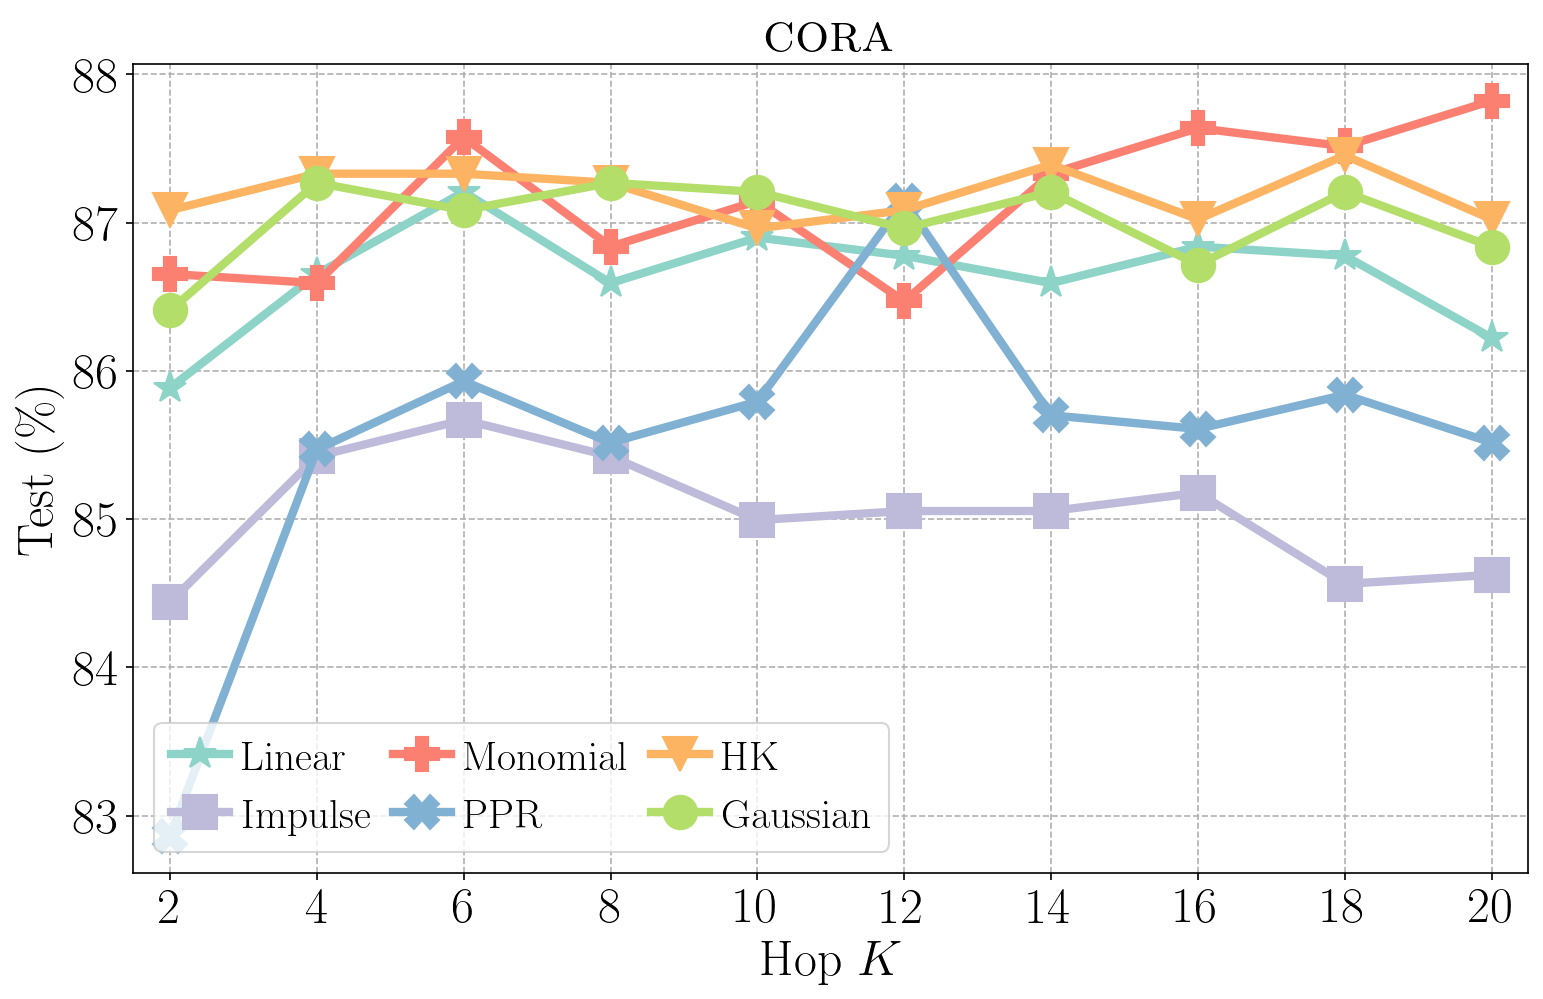

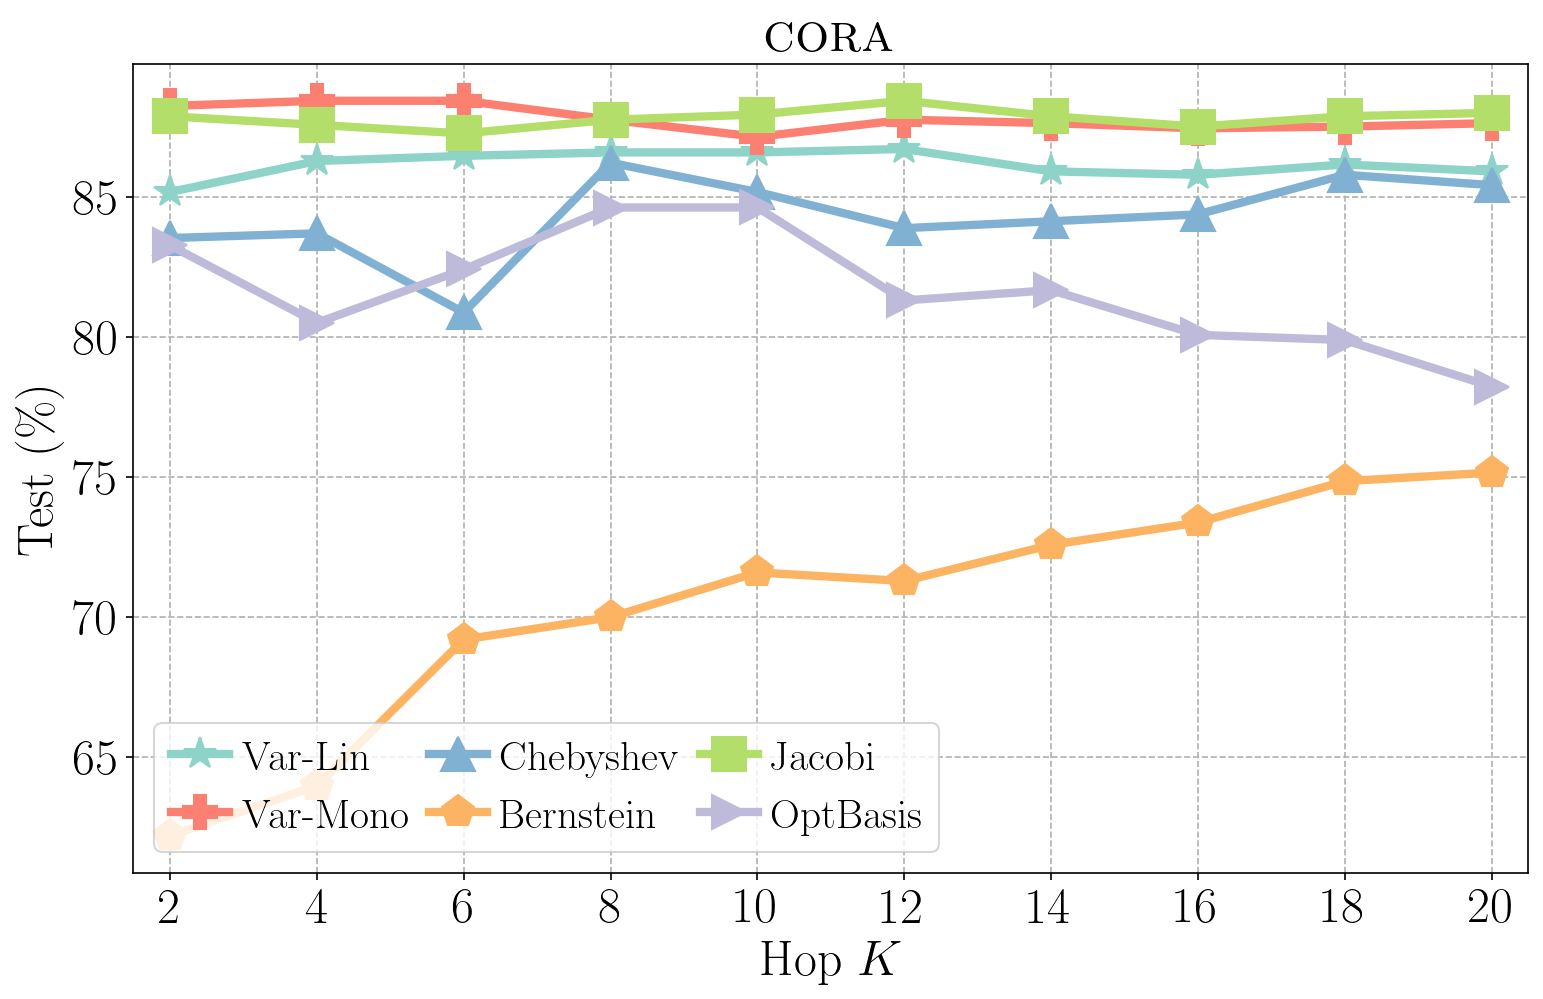

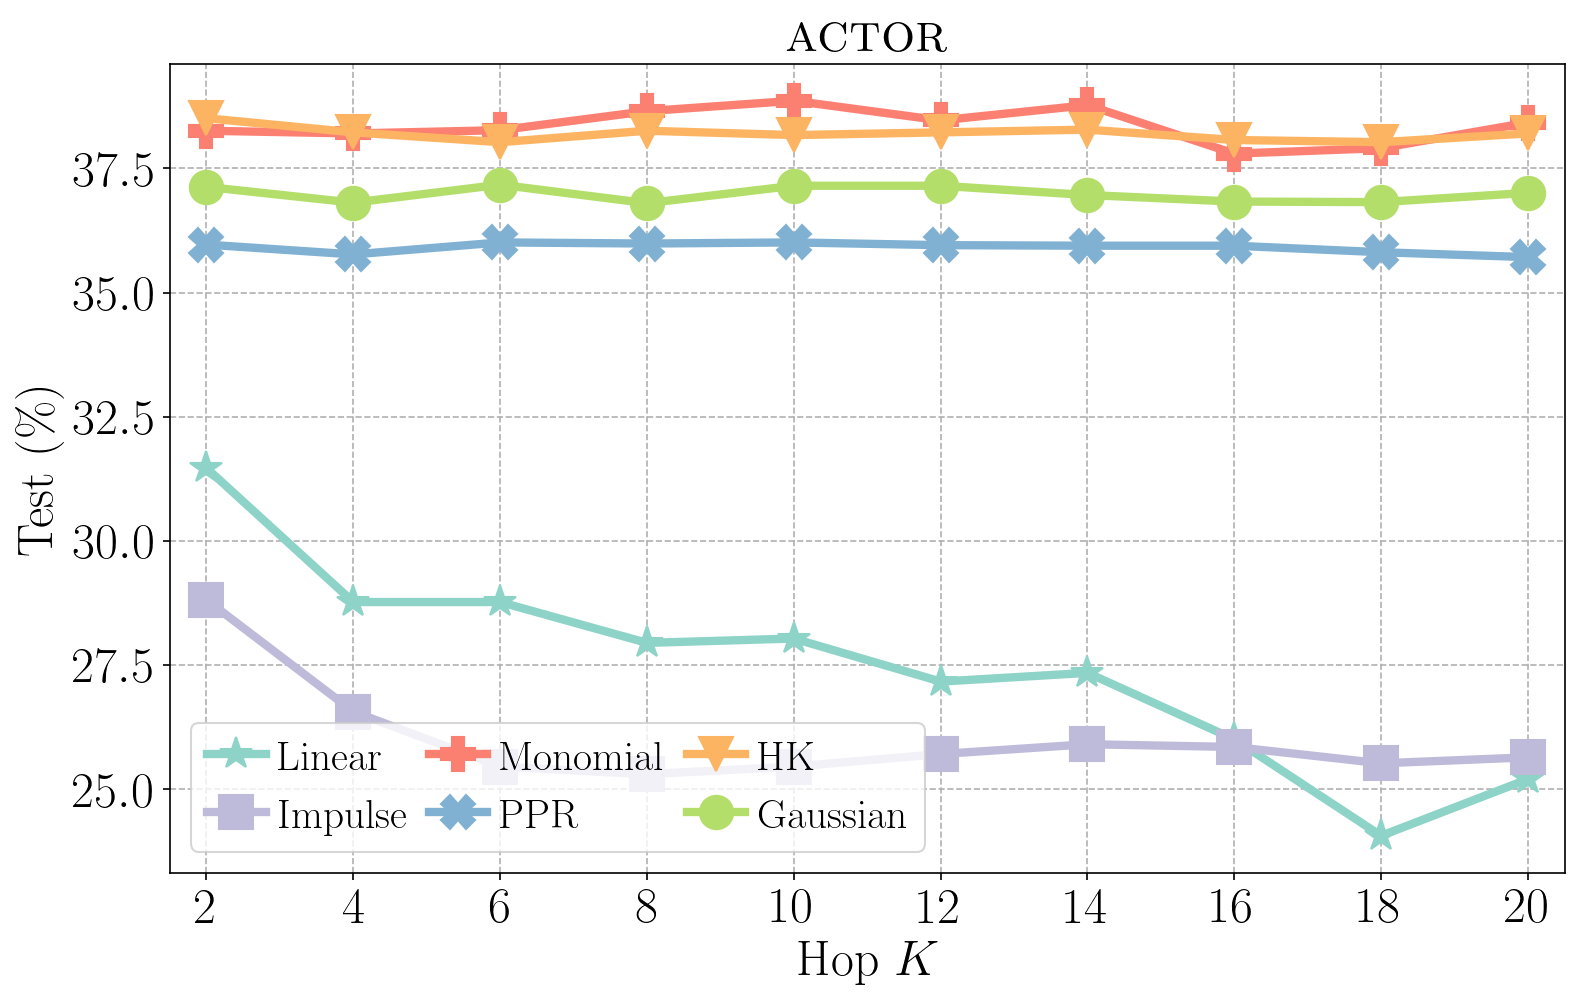

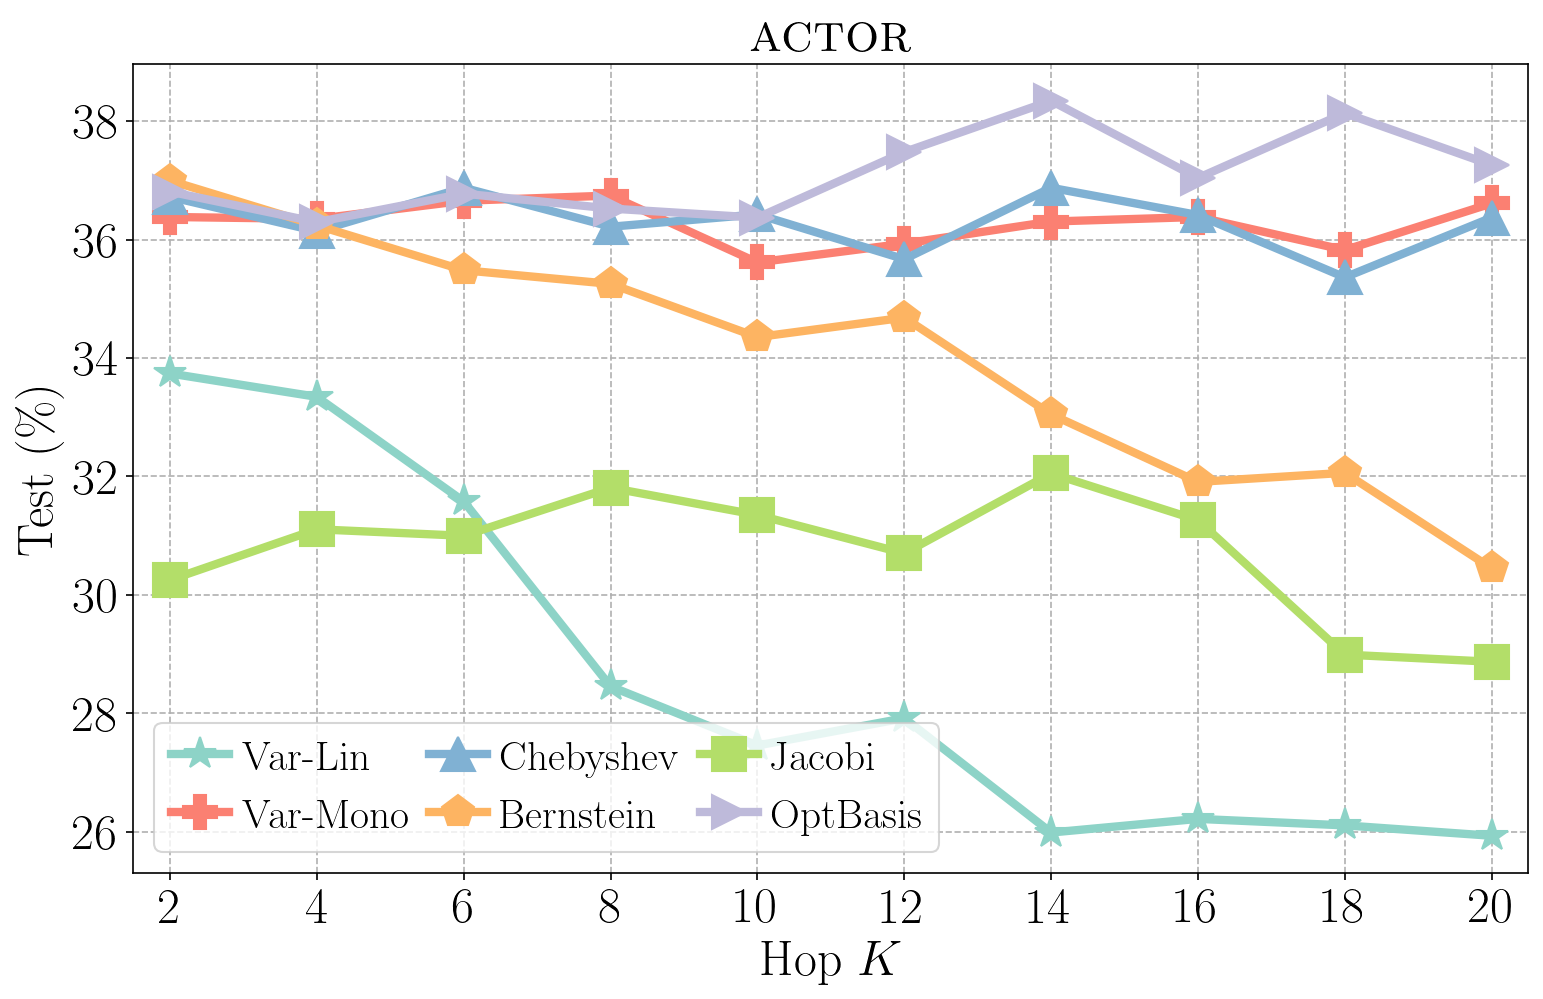

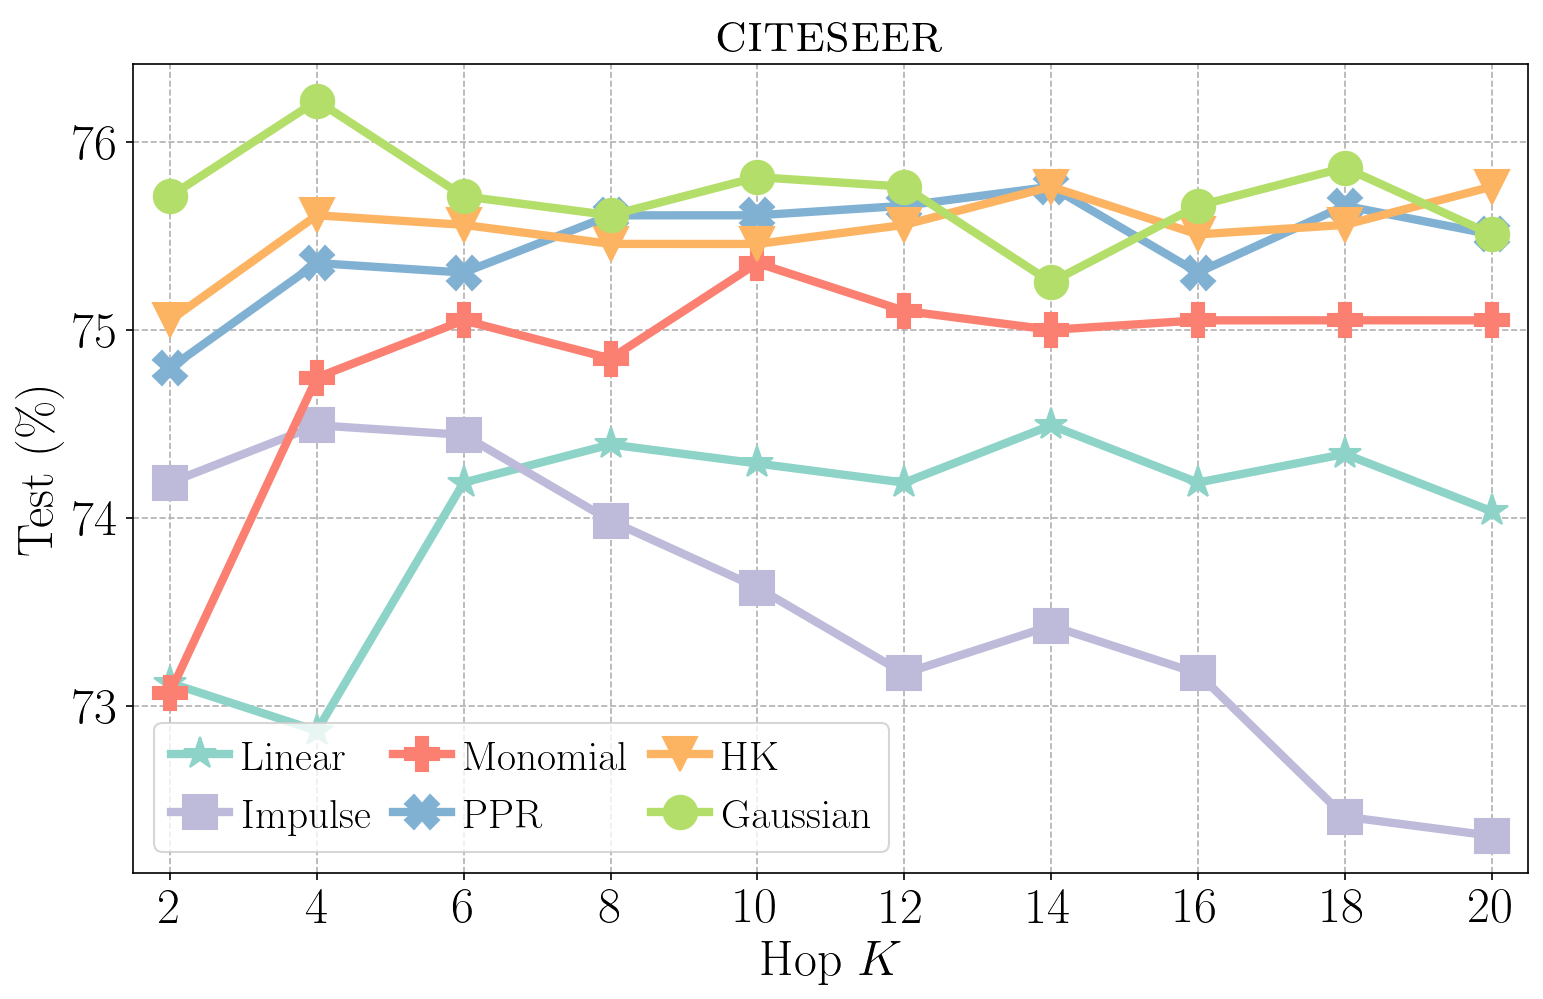

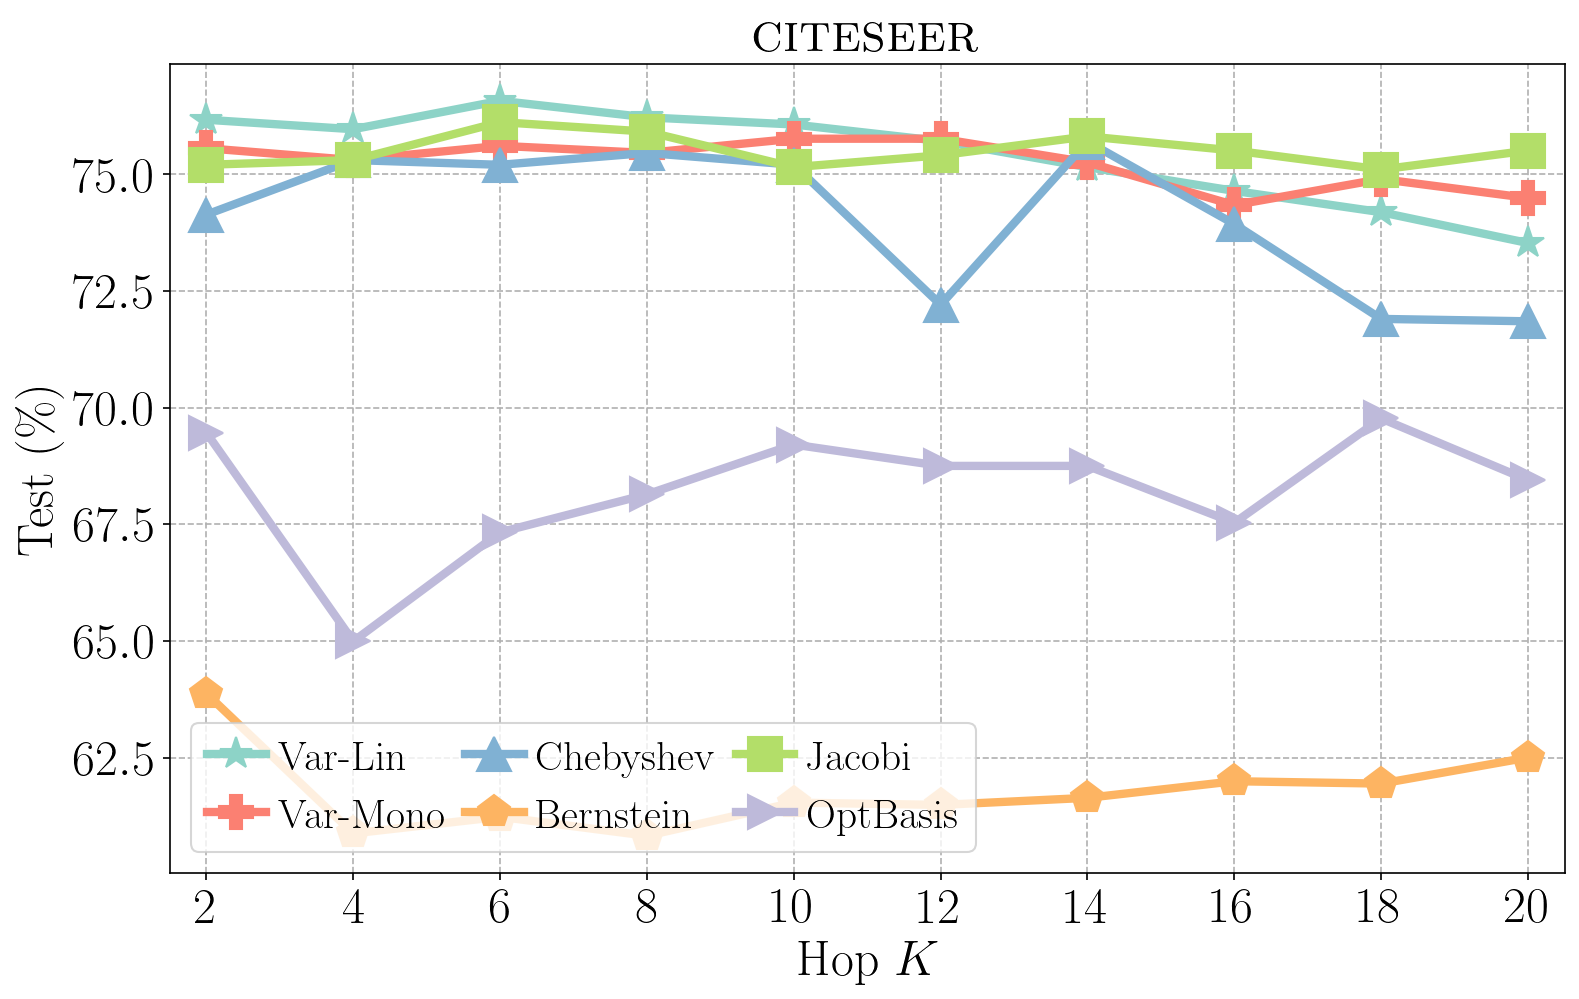

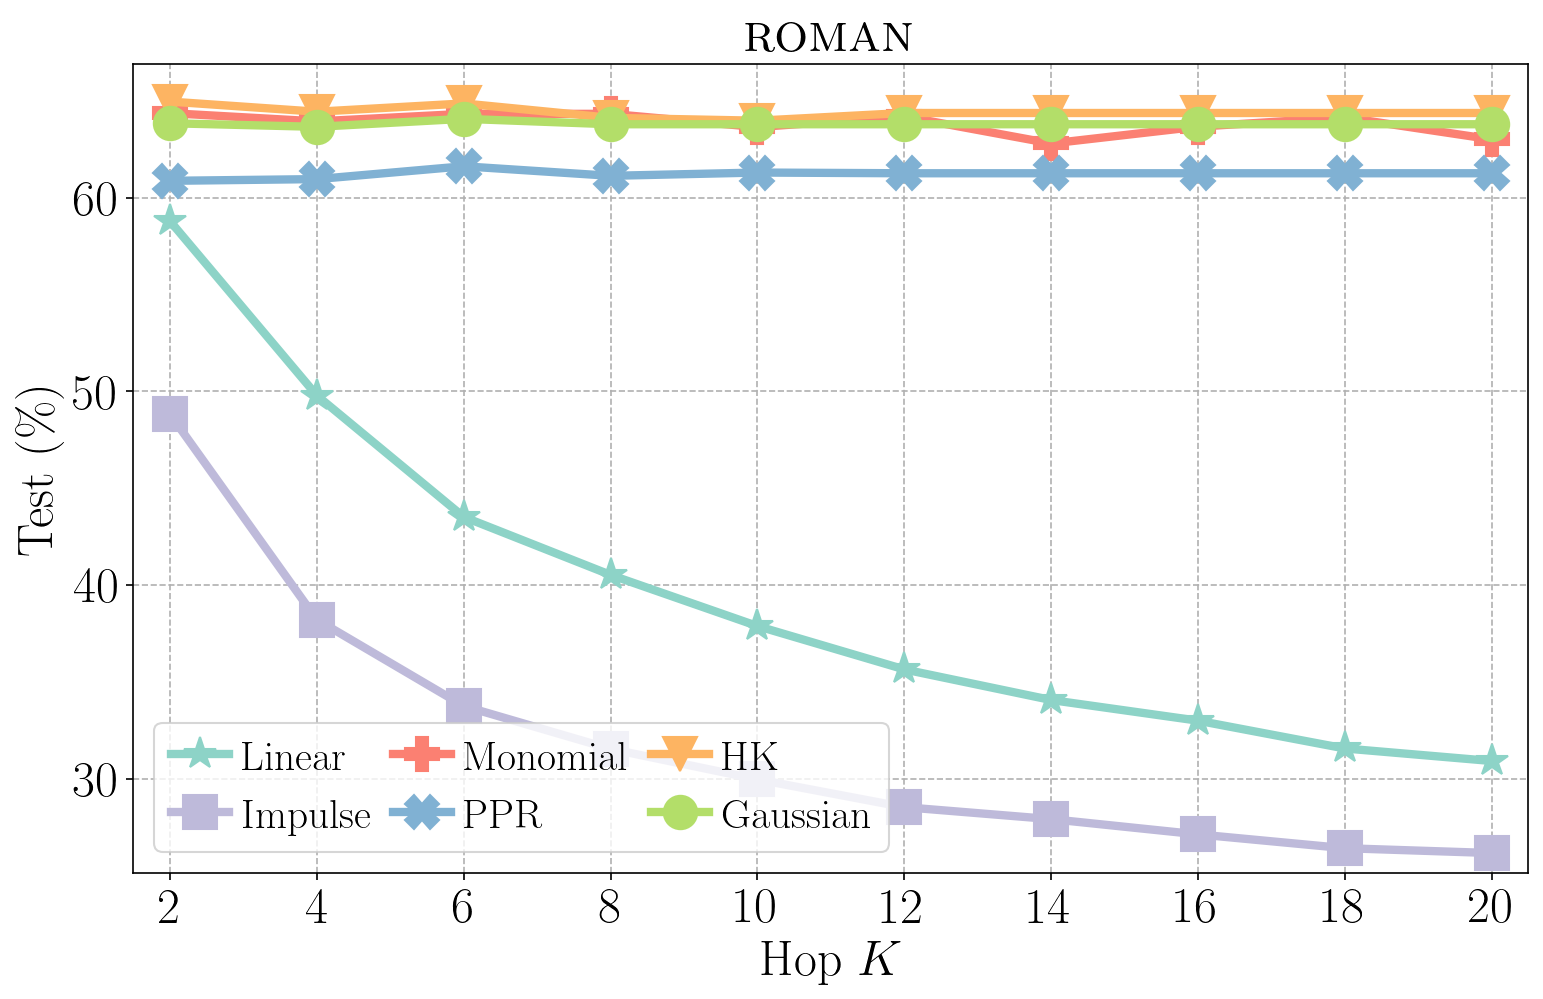

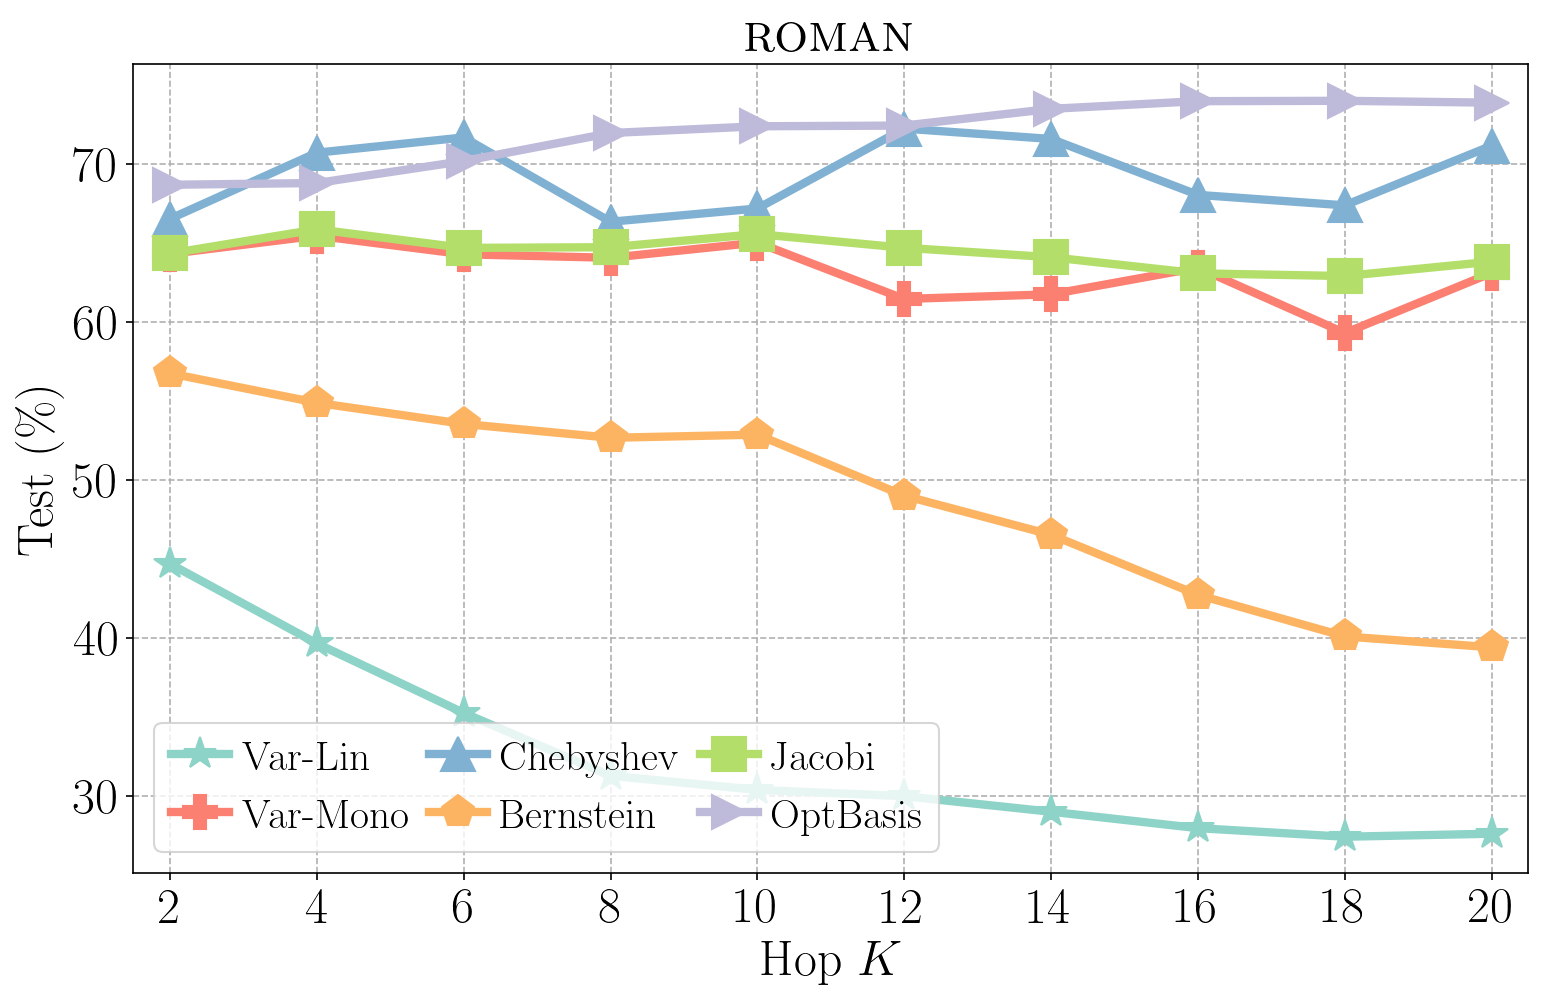

In [23]:
for d in ["cora", "actor", "citeseer", "roman_empire",]:
    fig1, ax1 = plot_acchop(d, argdct_fix)
    fig2, ax2 = plot_acchop(d, argdct_var)
    if issave:
        fig1.savefig(f'./figs/hop_fix_{d}_par.pdf', bbox_inches='tight')
        fig2.savefig(f'./figs/hop_var_{d}_par.pdf', bbox_inches='tight')

/tmp/ipykernel_381538/1191922786.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(12, 7), dpi=(150 if issave else 72))


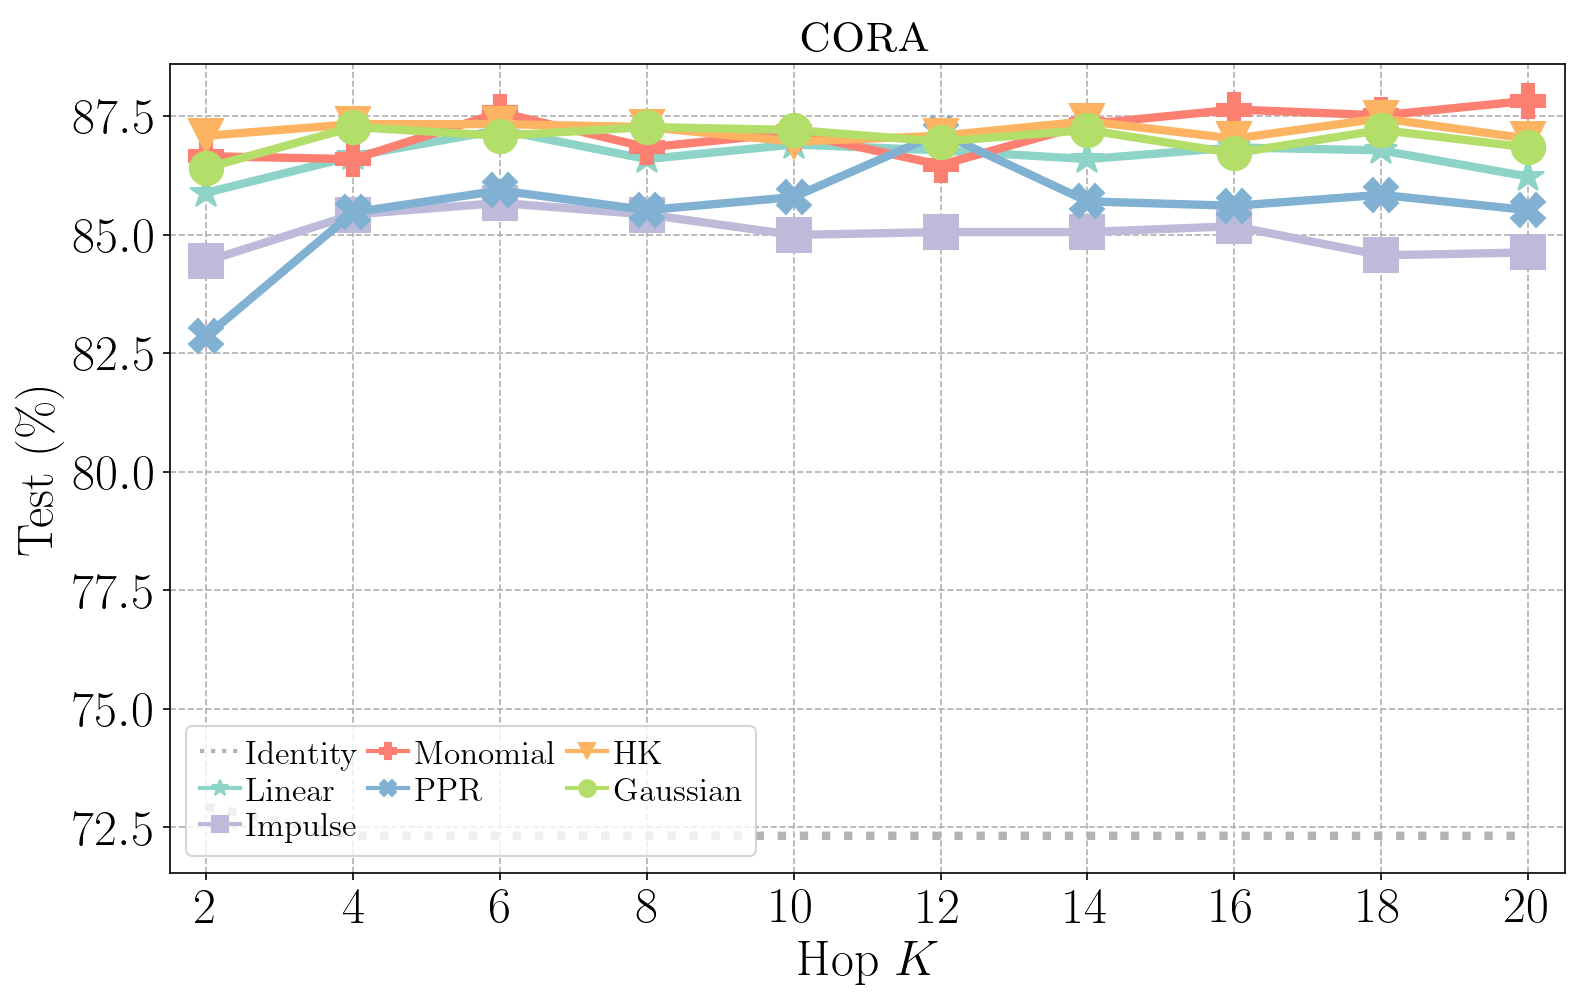

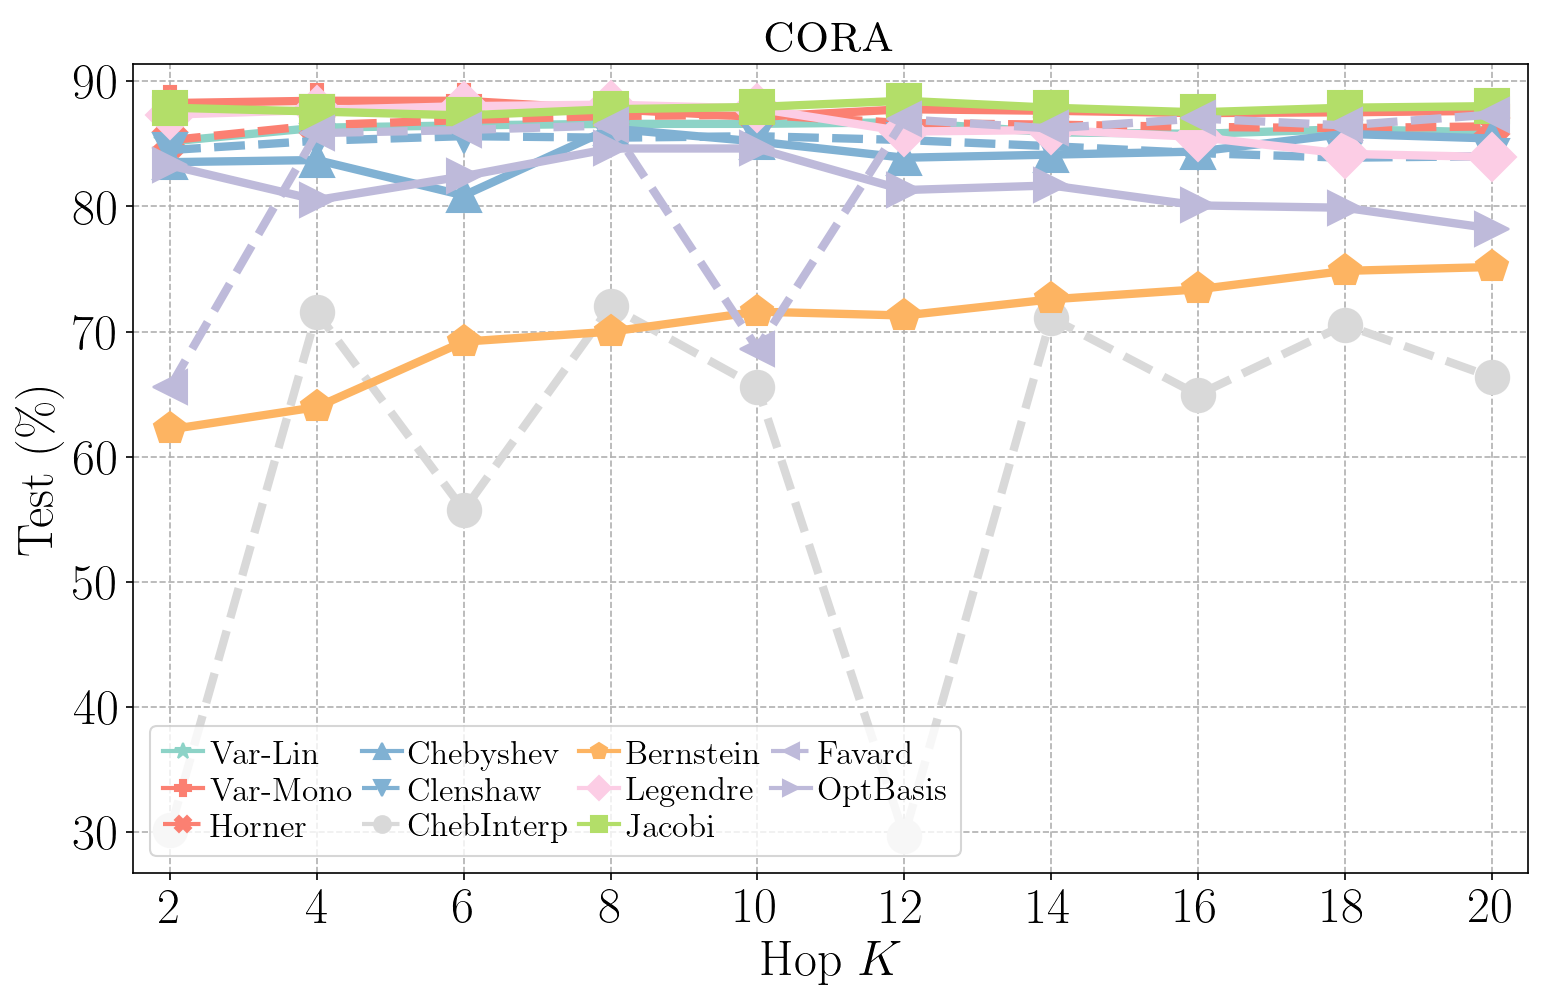

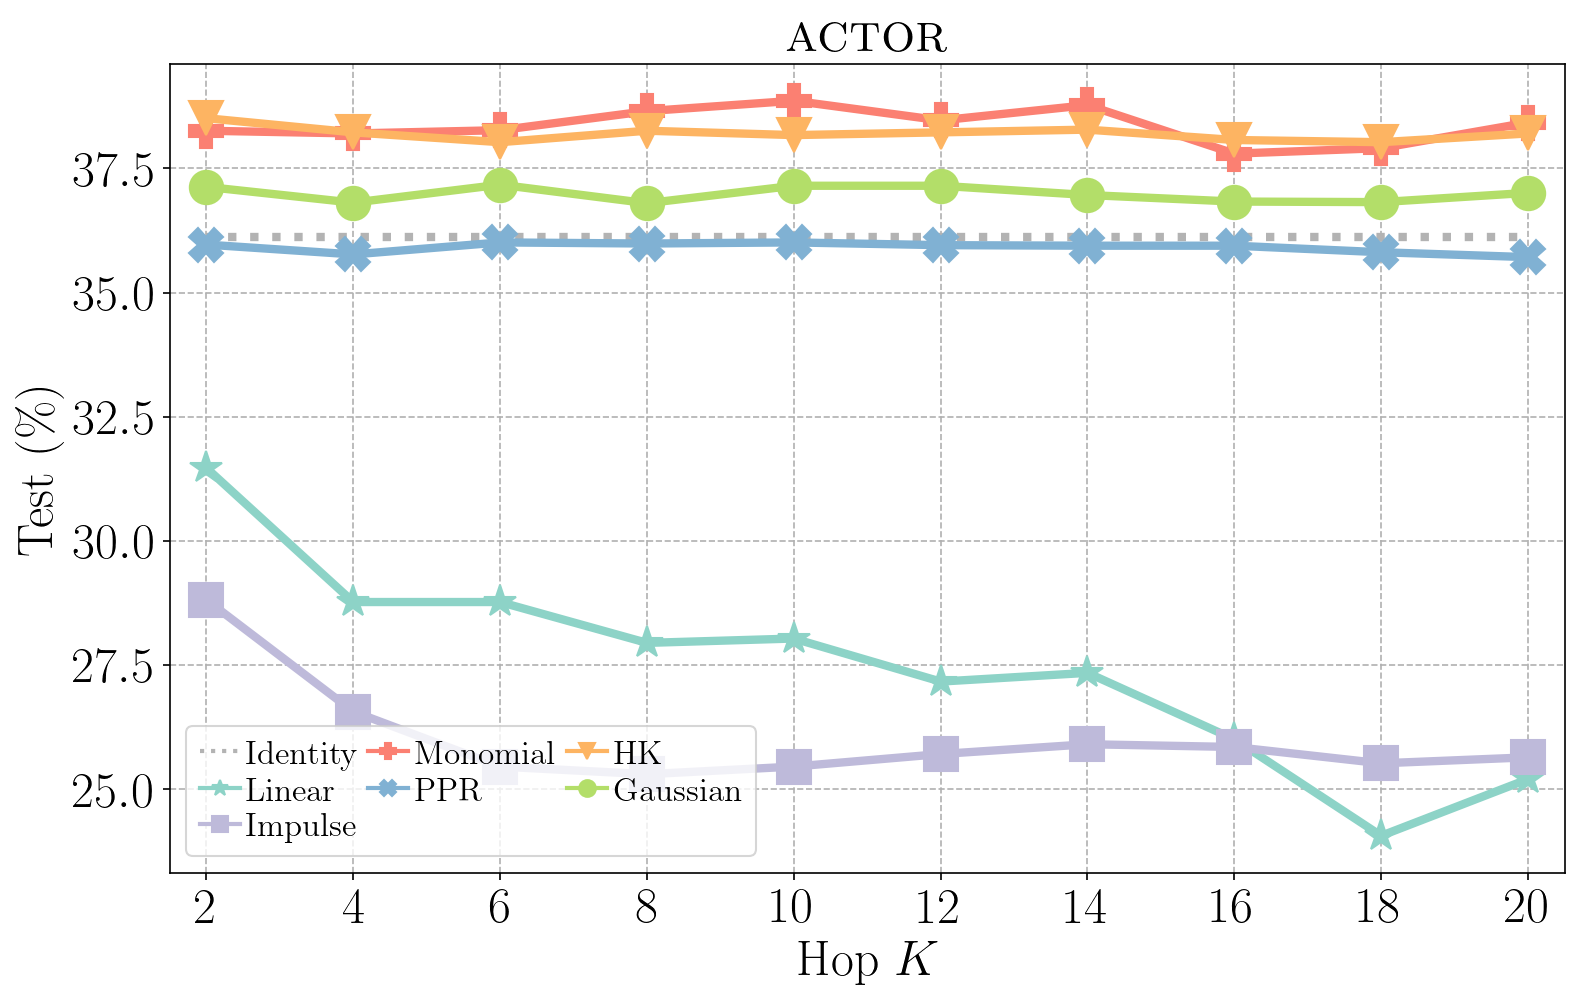

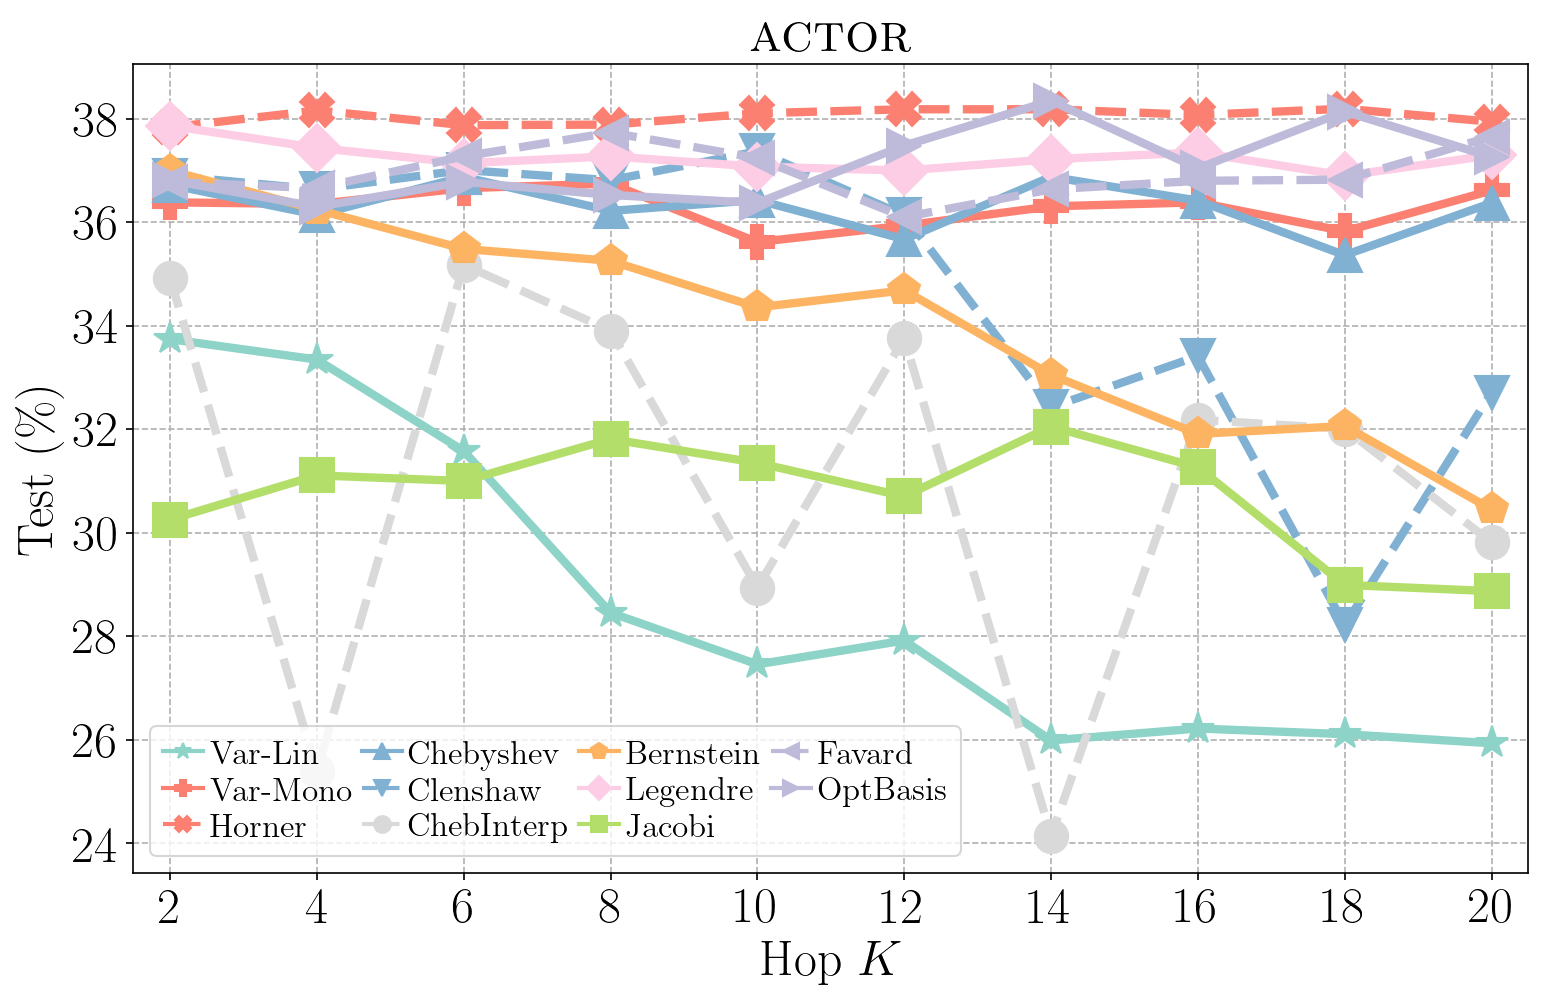

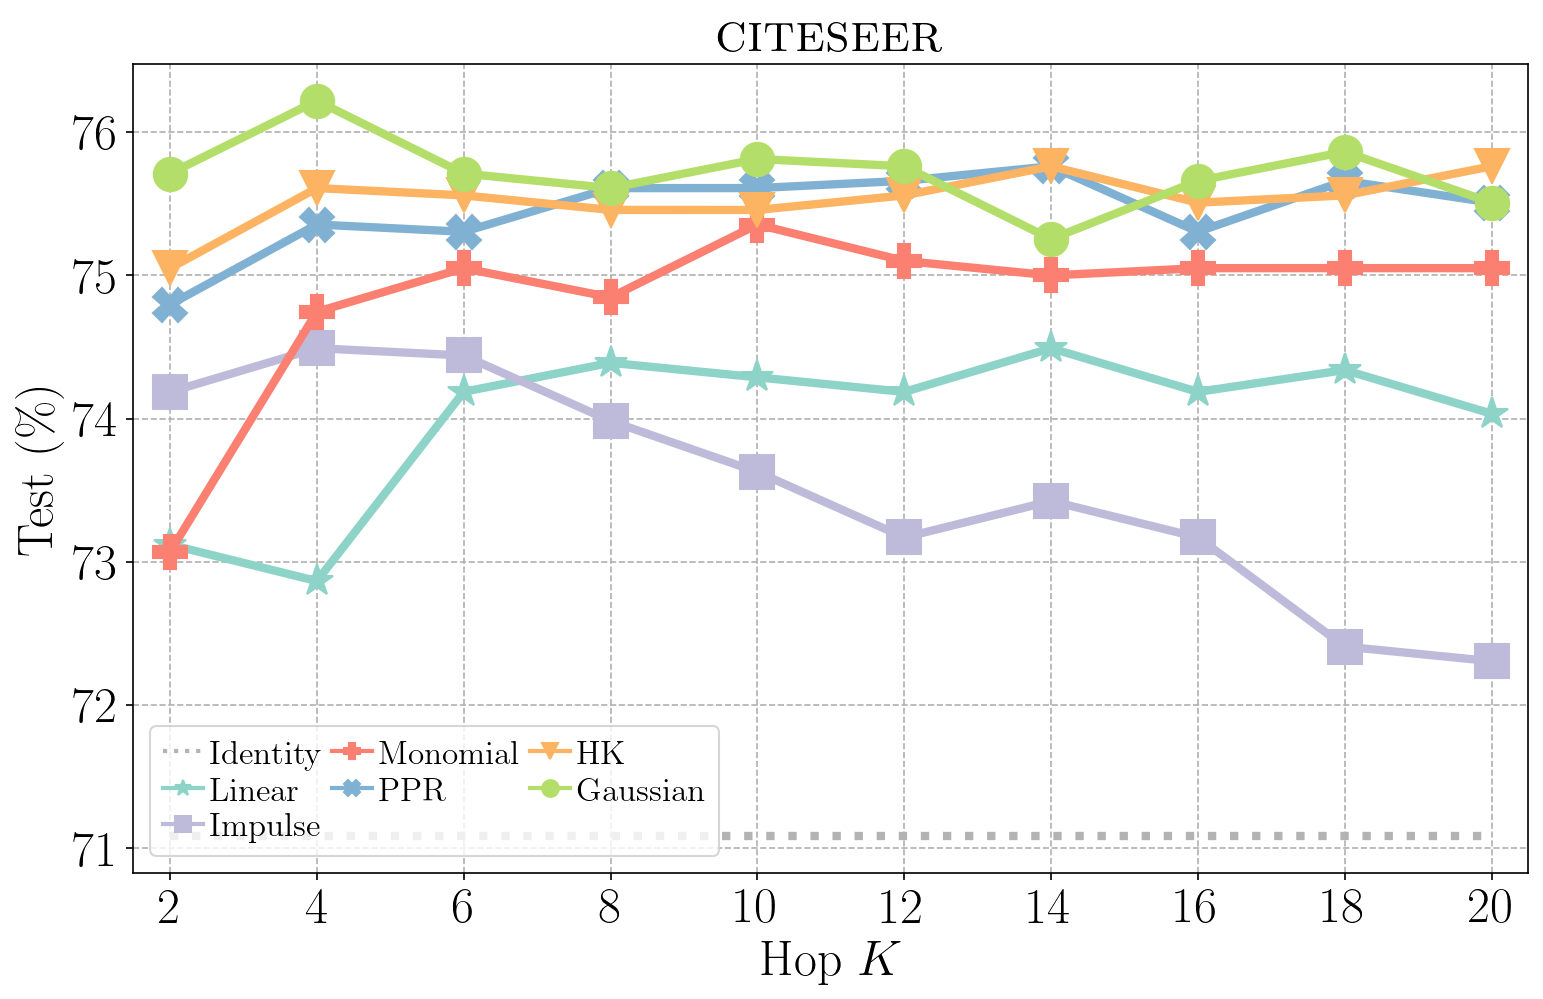

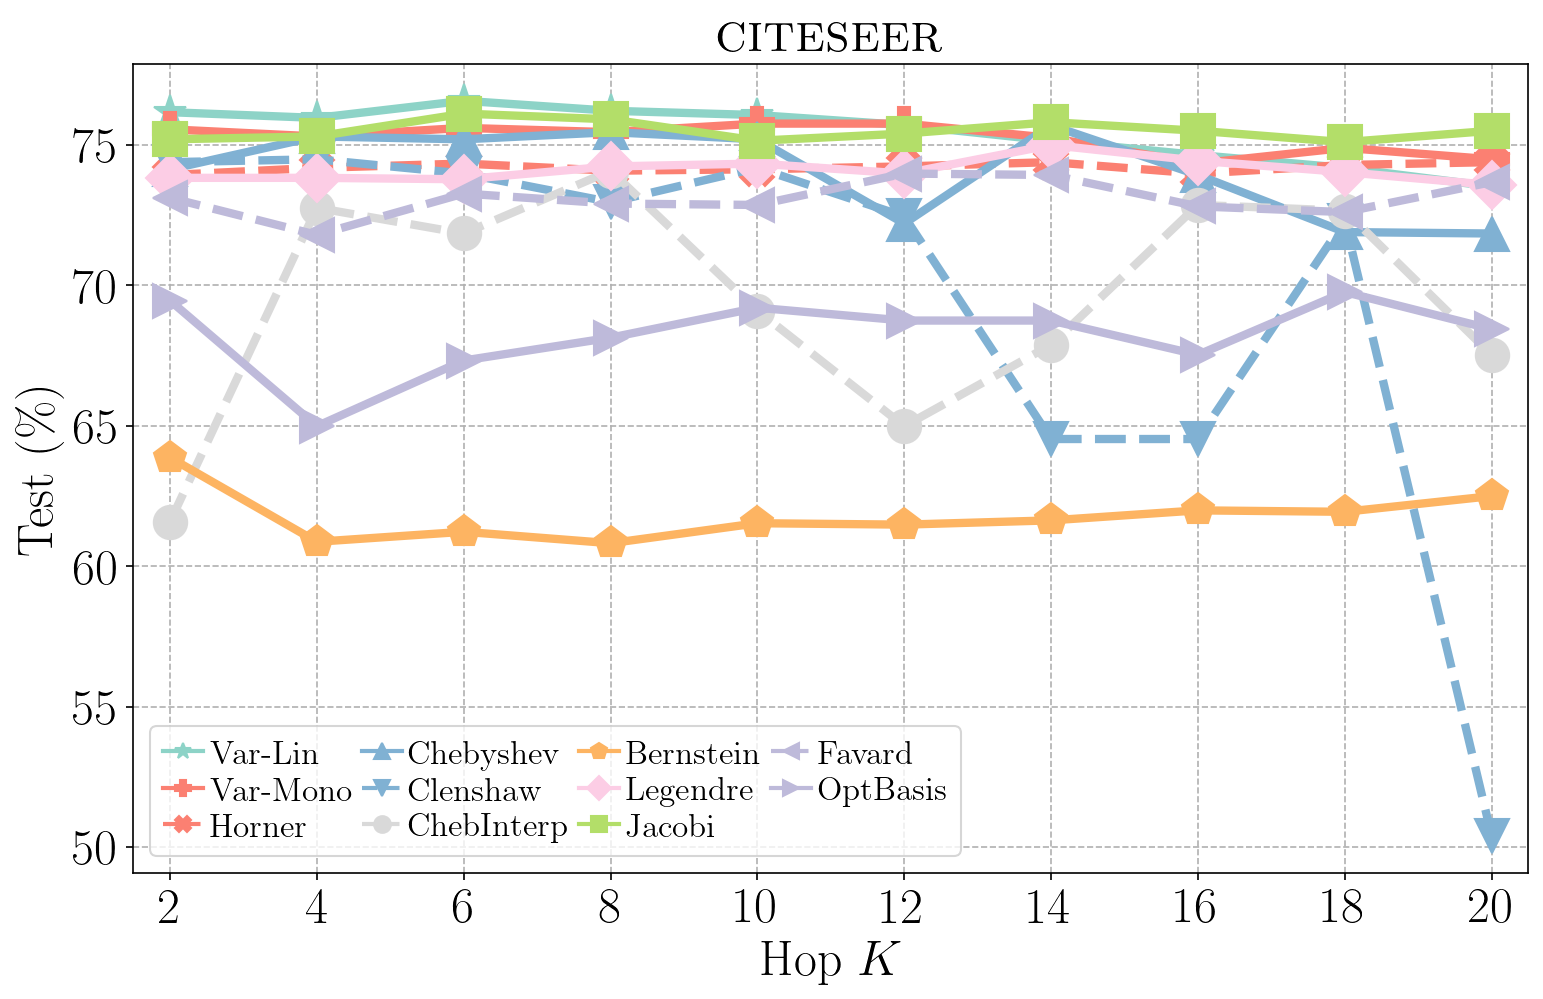

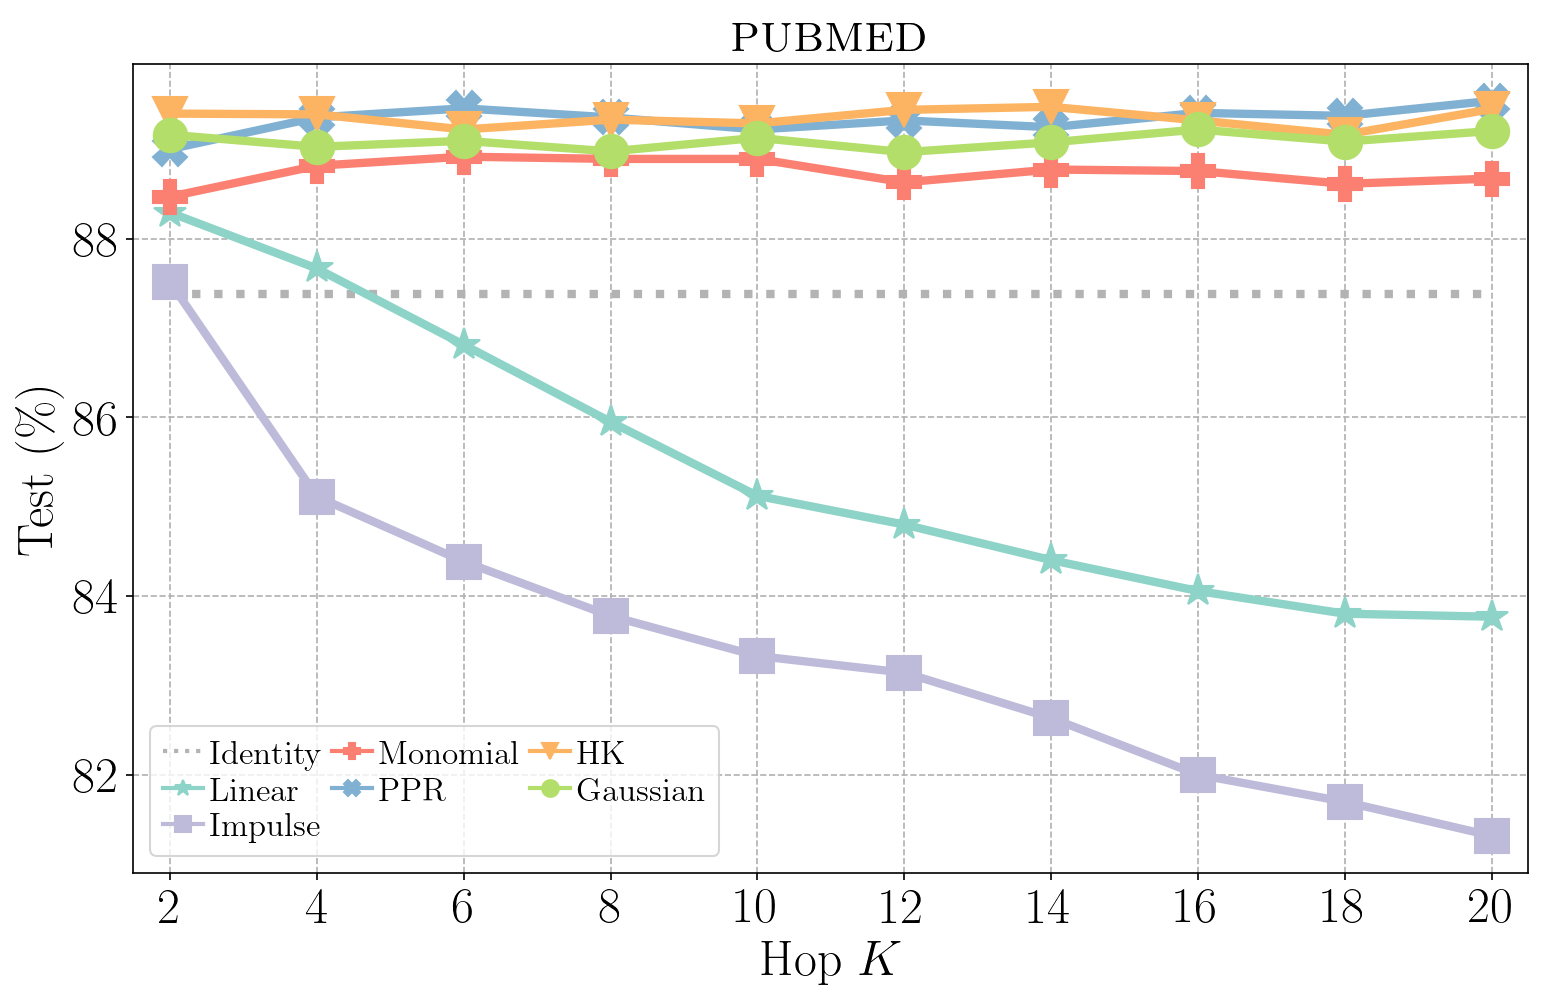

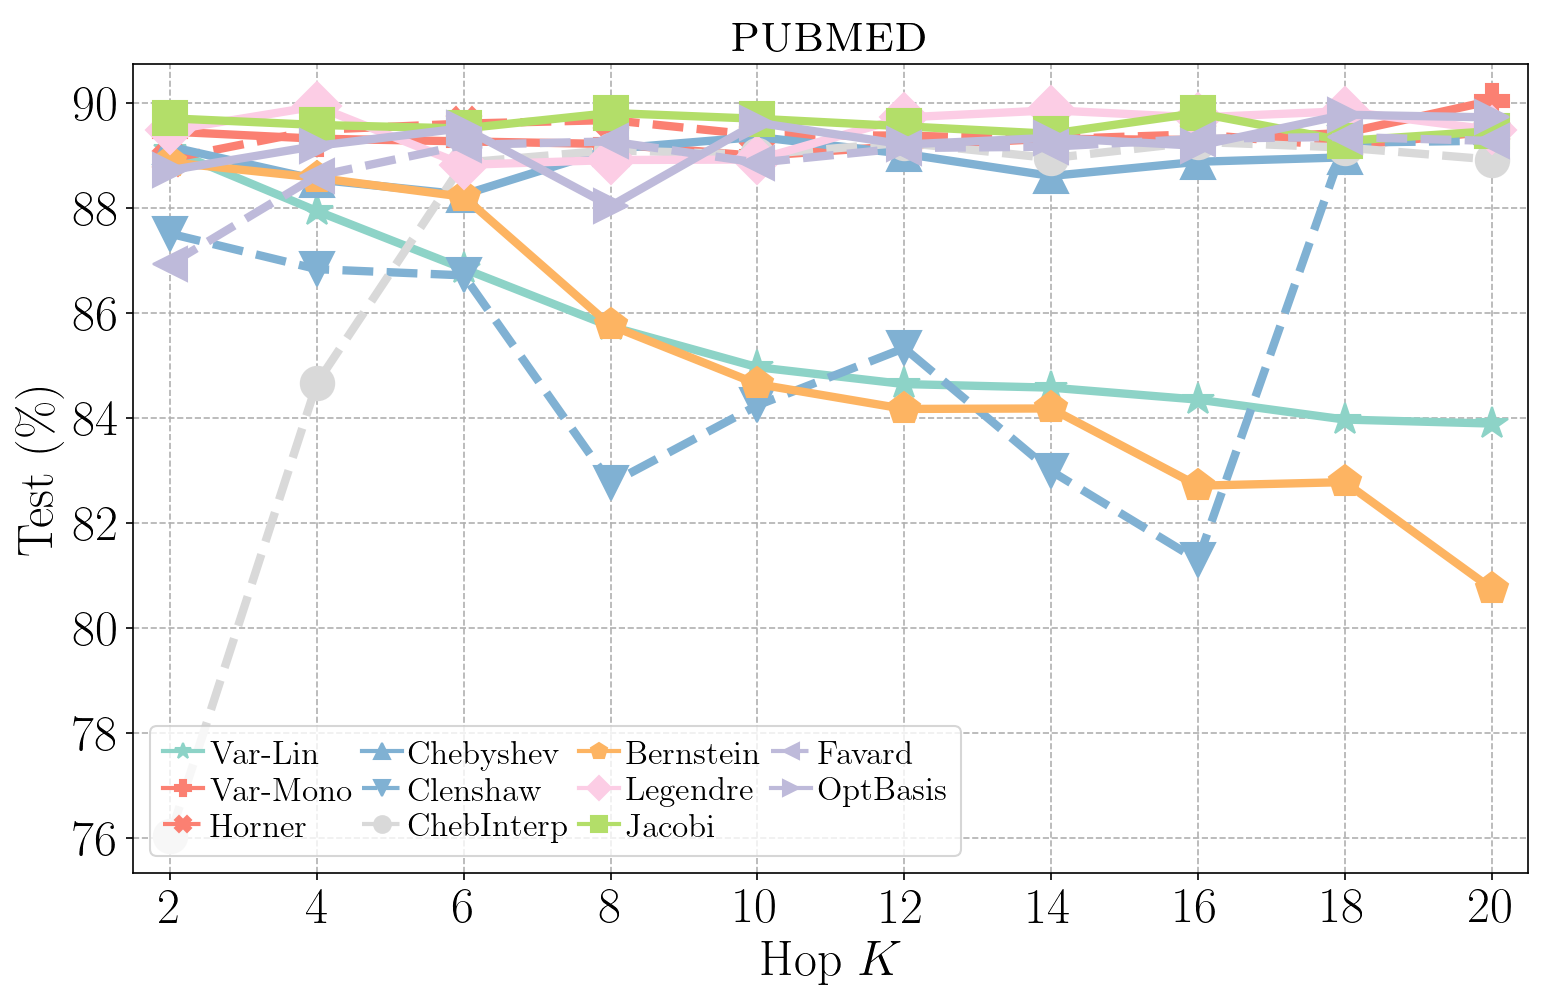

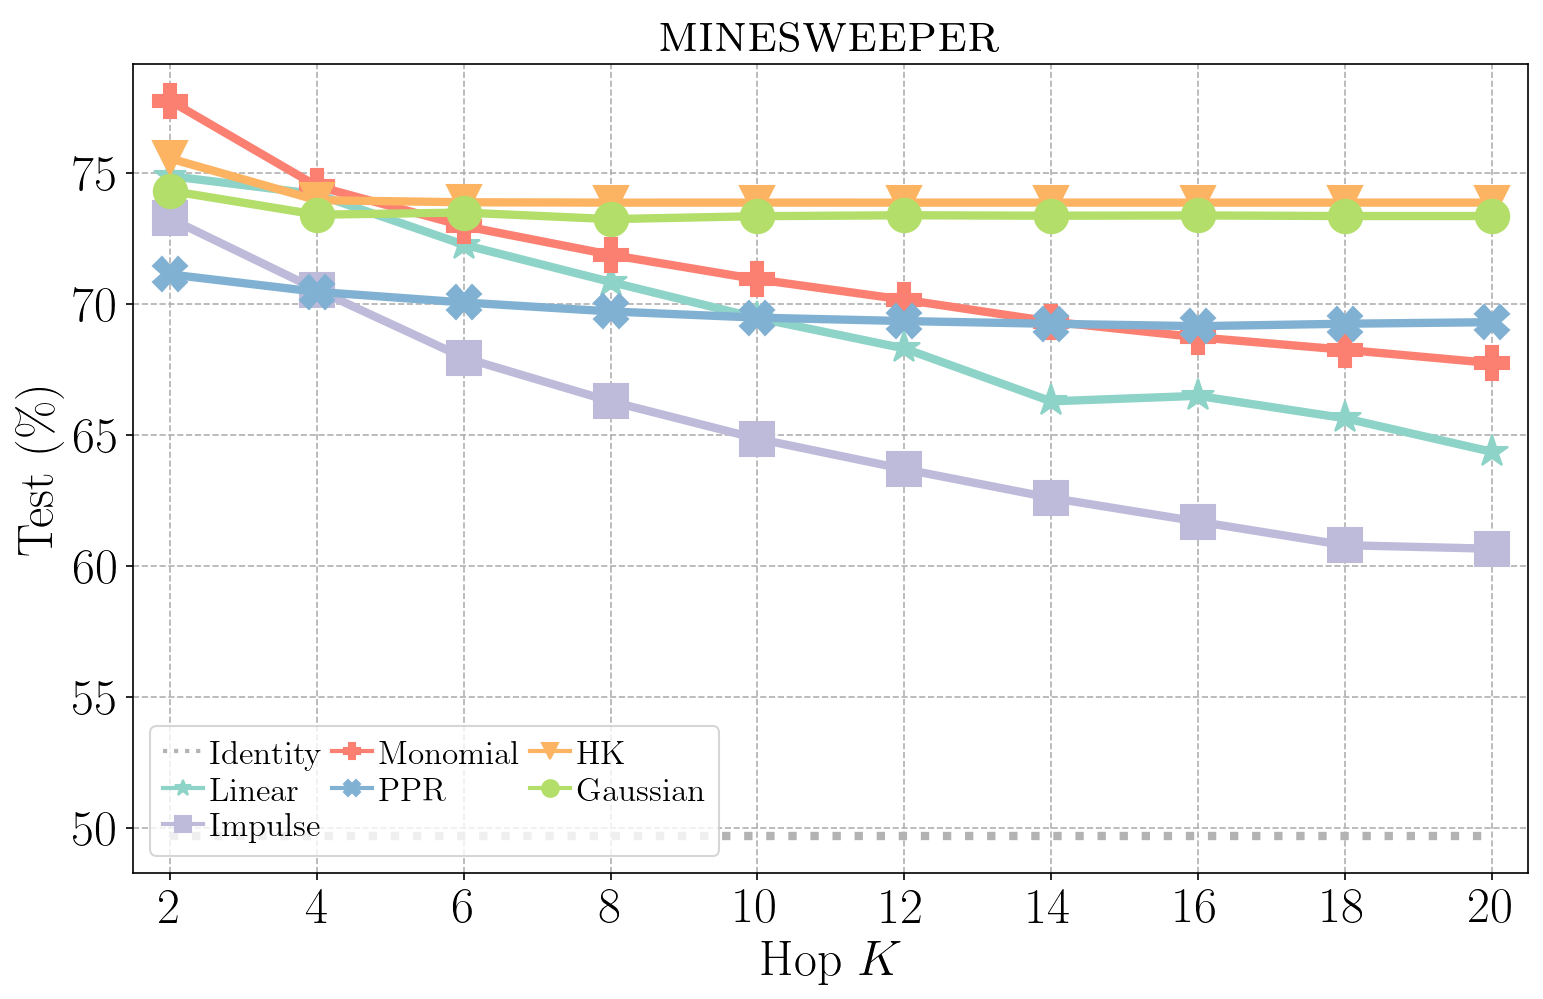

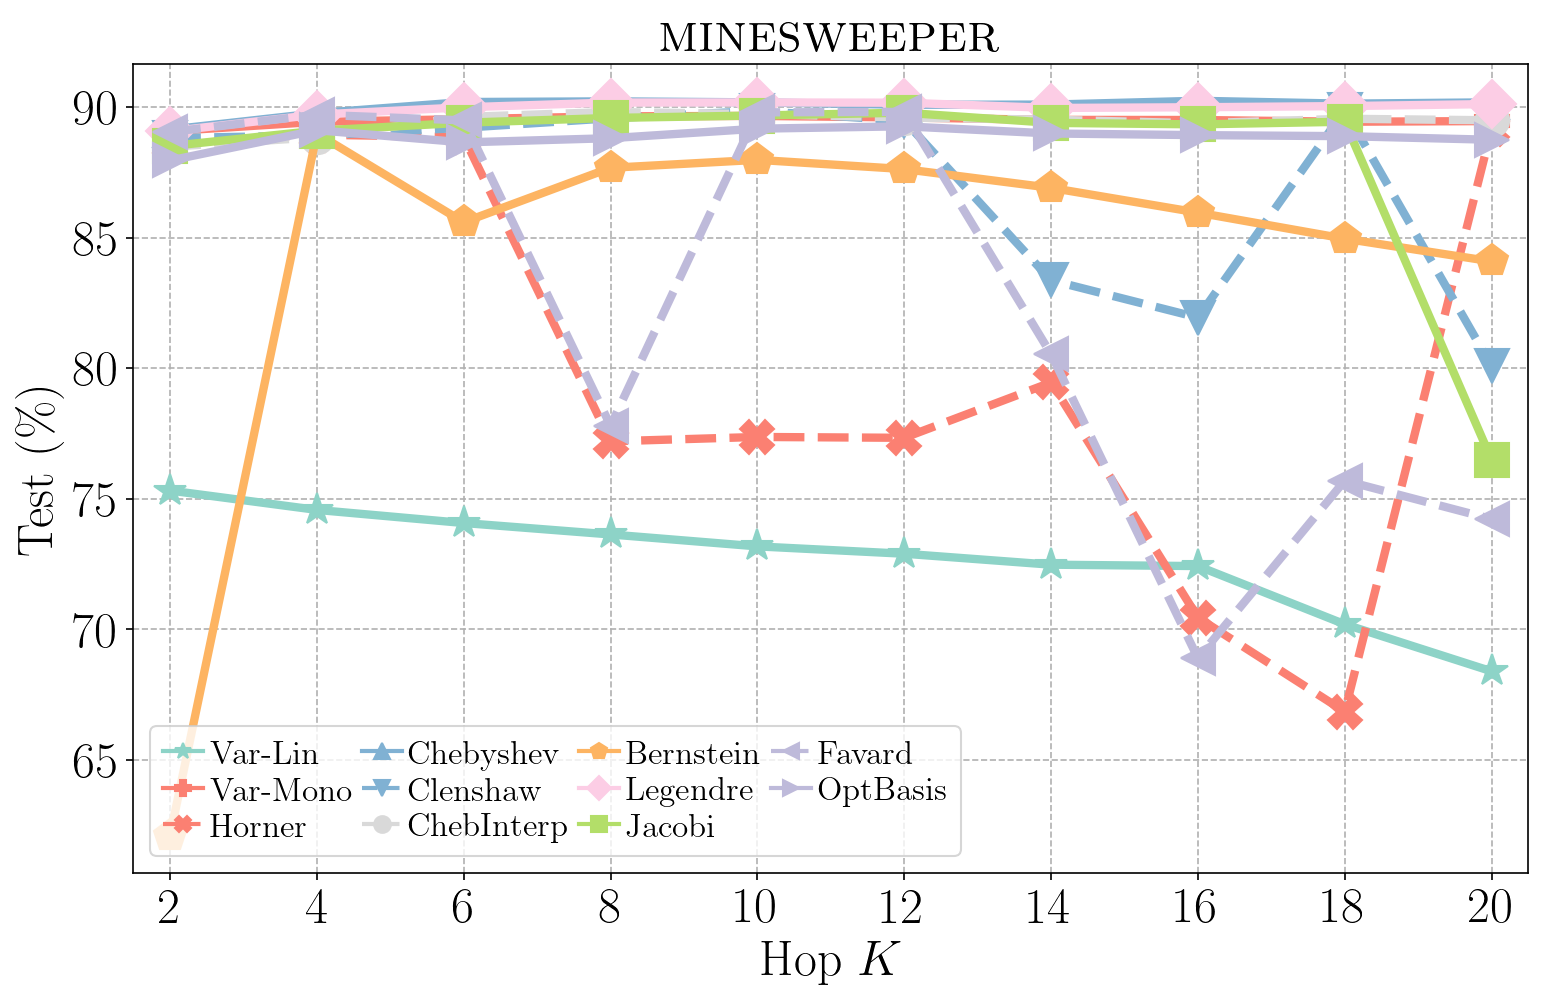

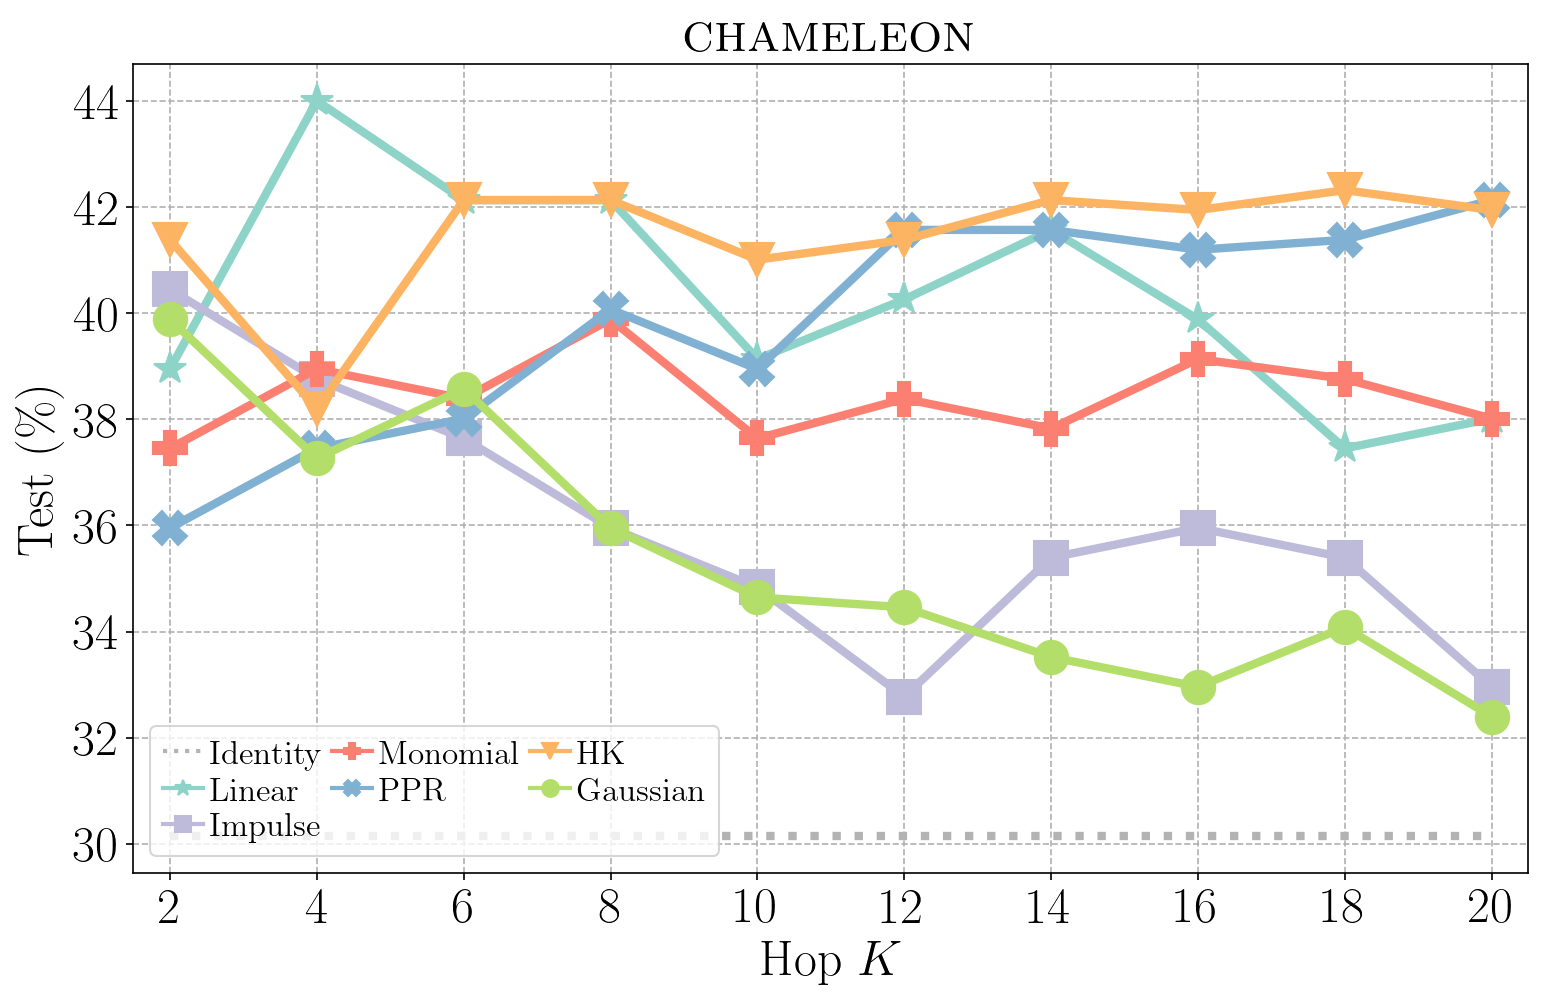

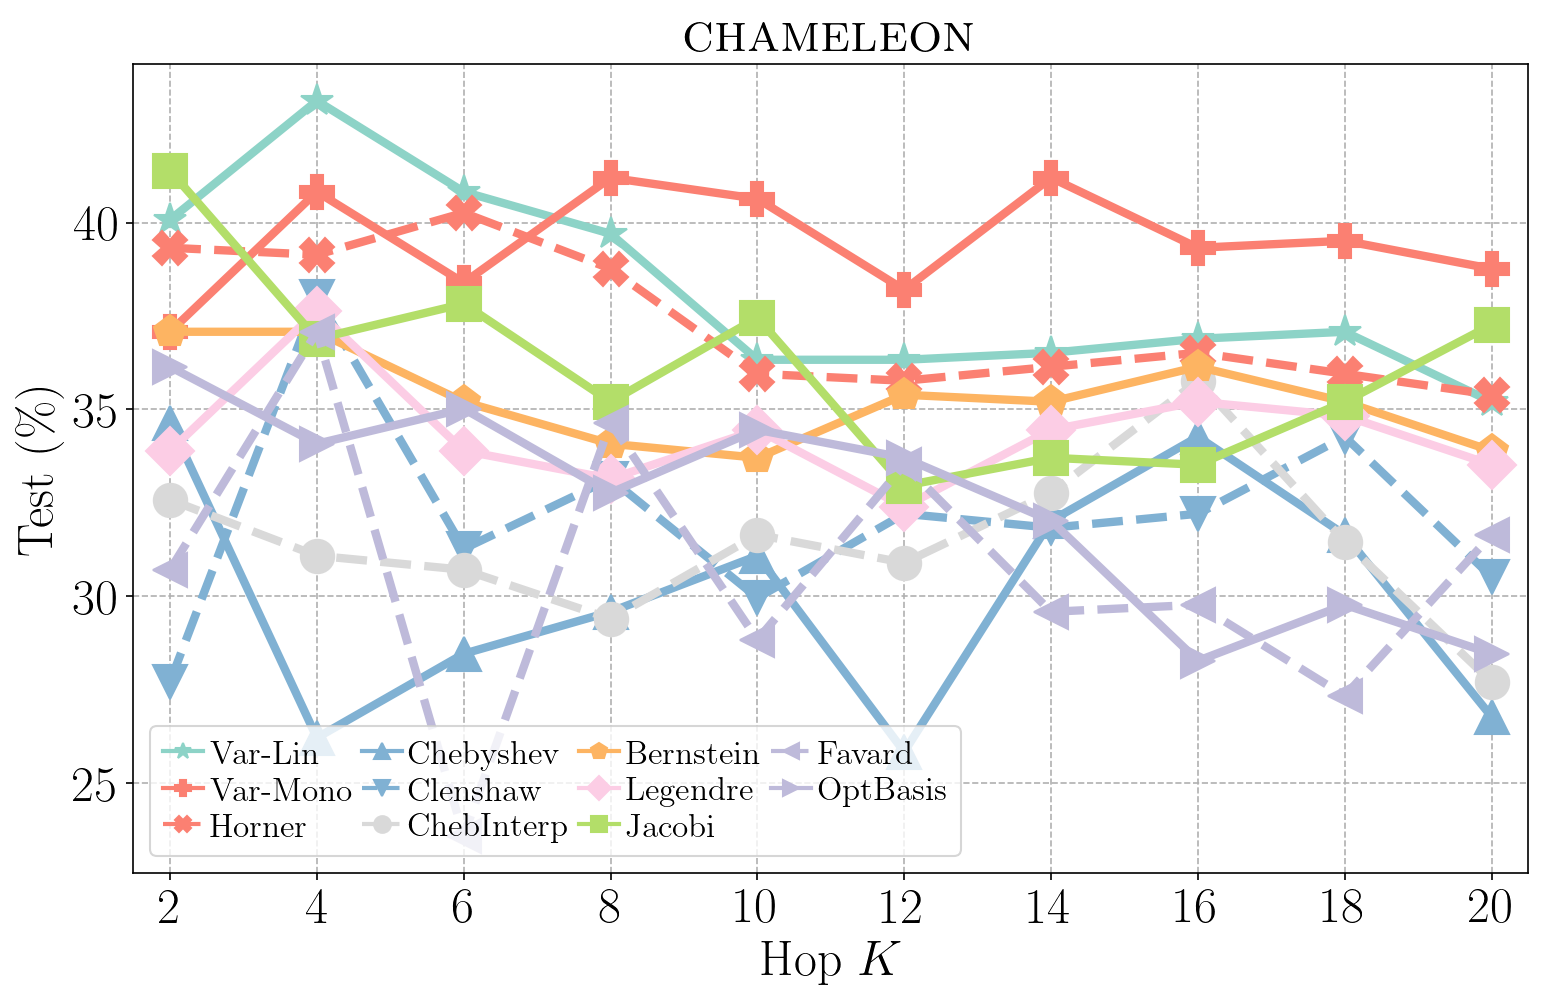

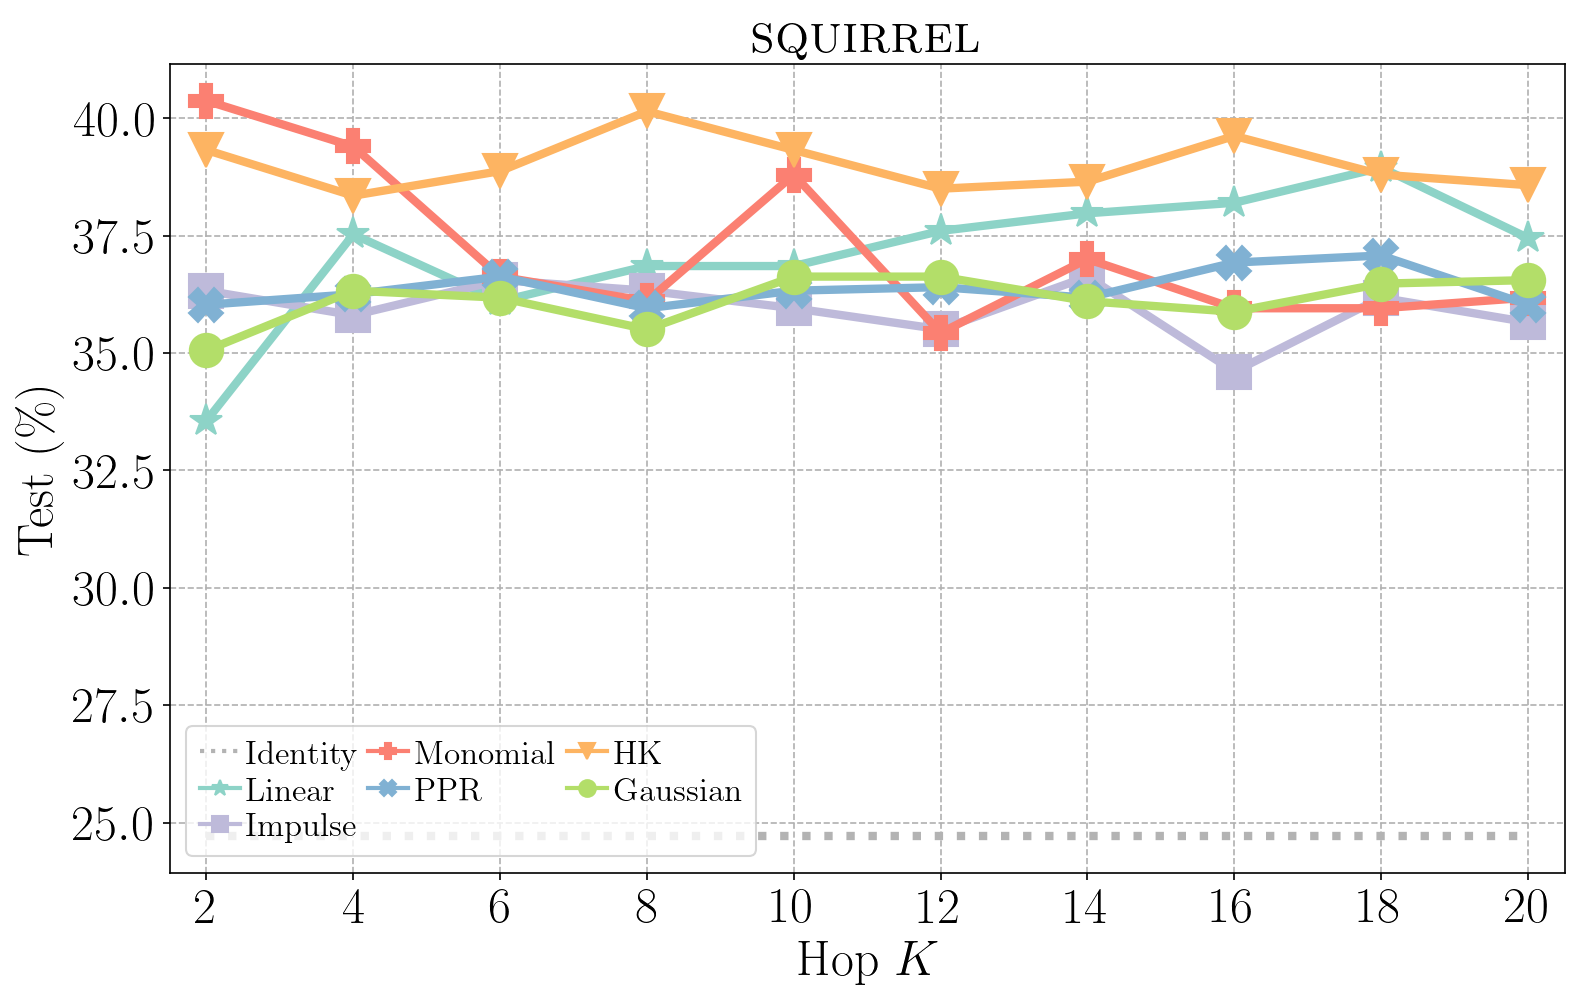

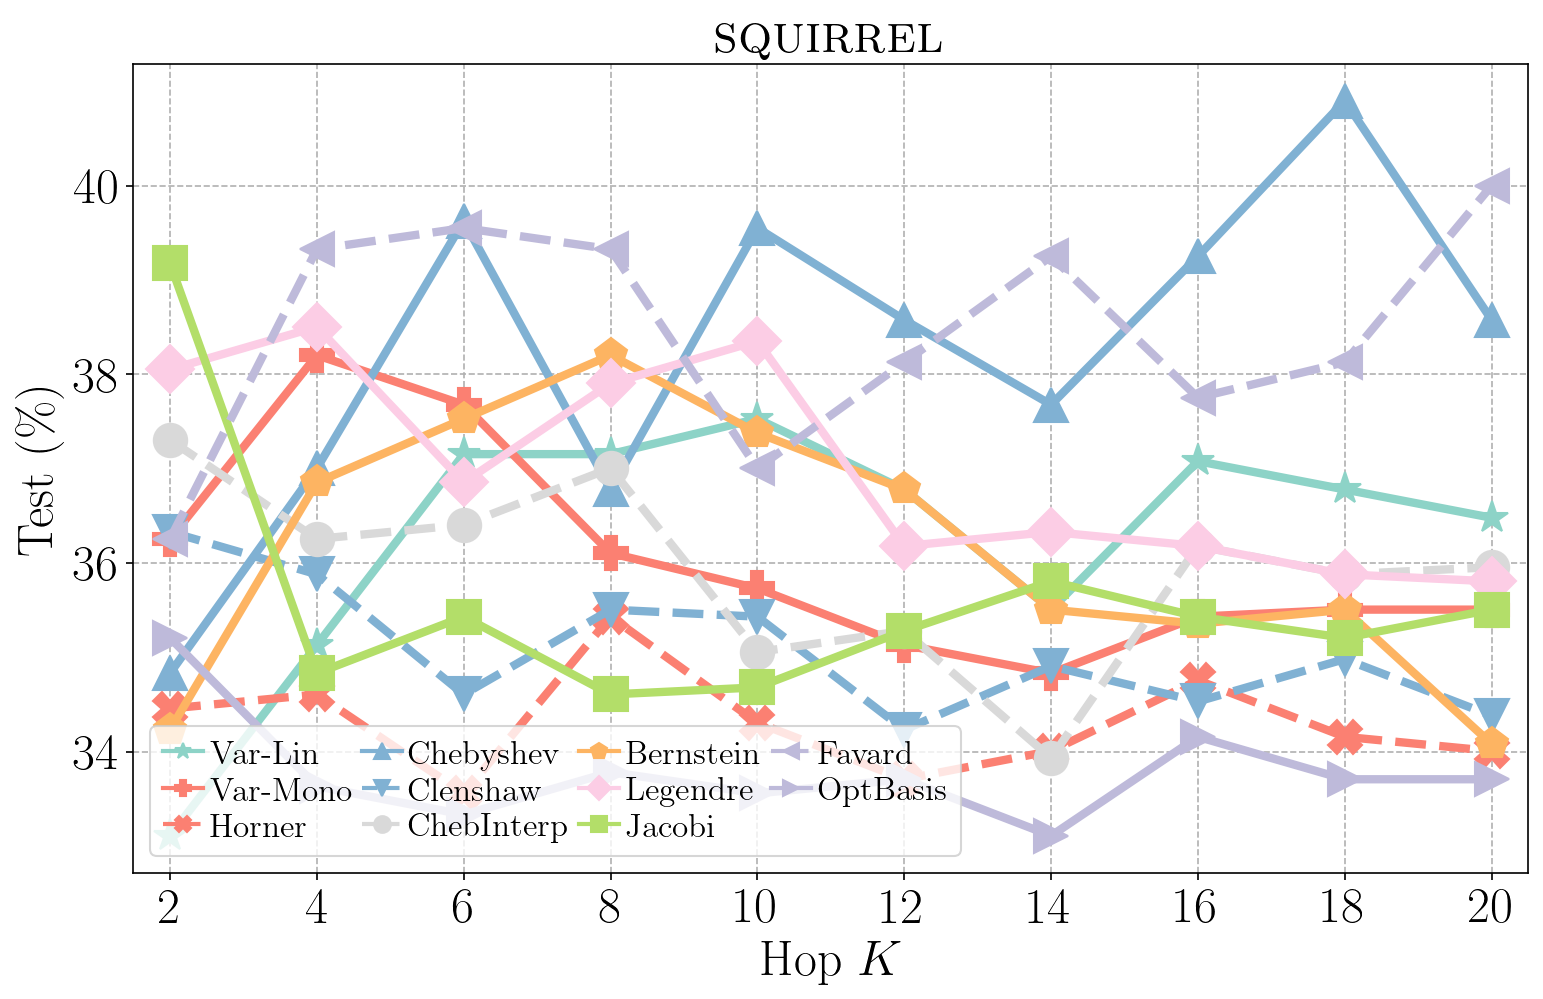

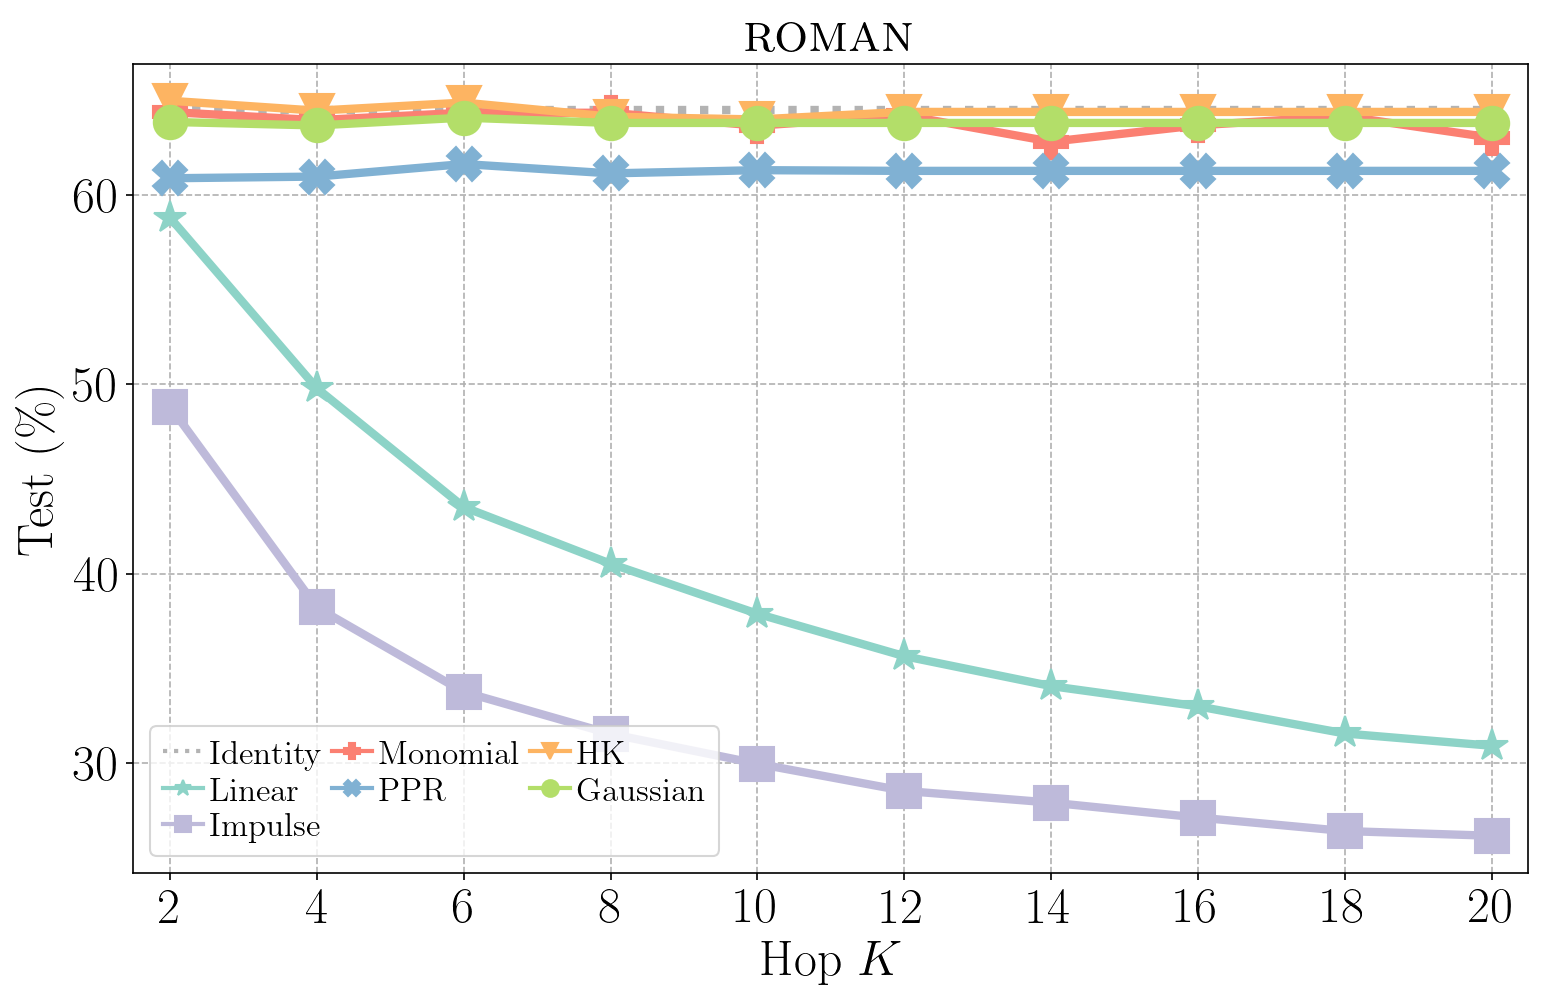

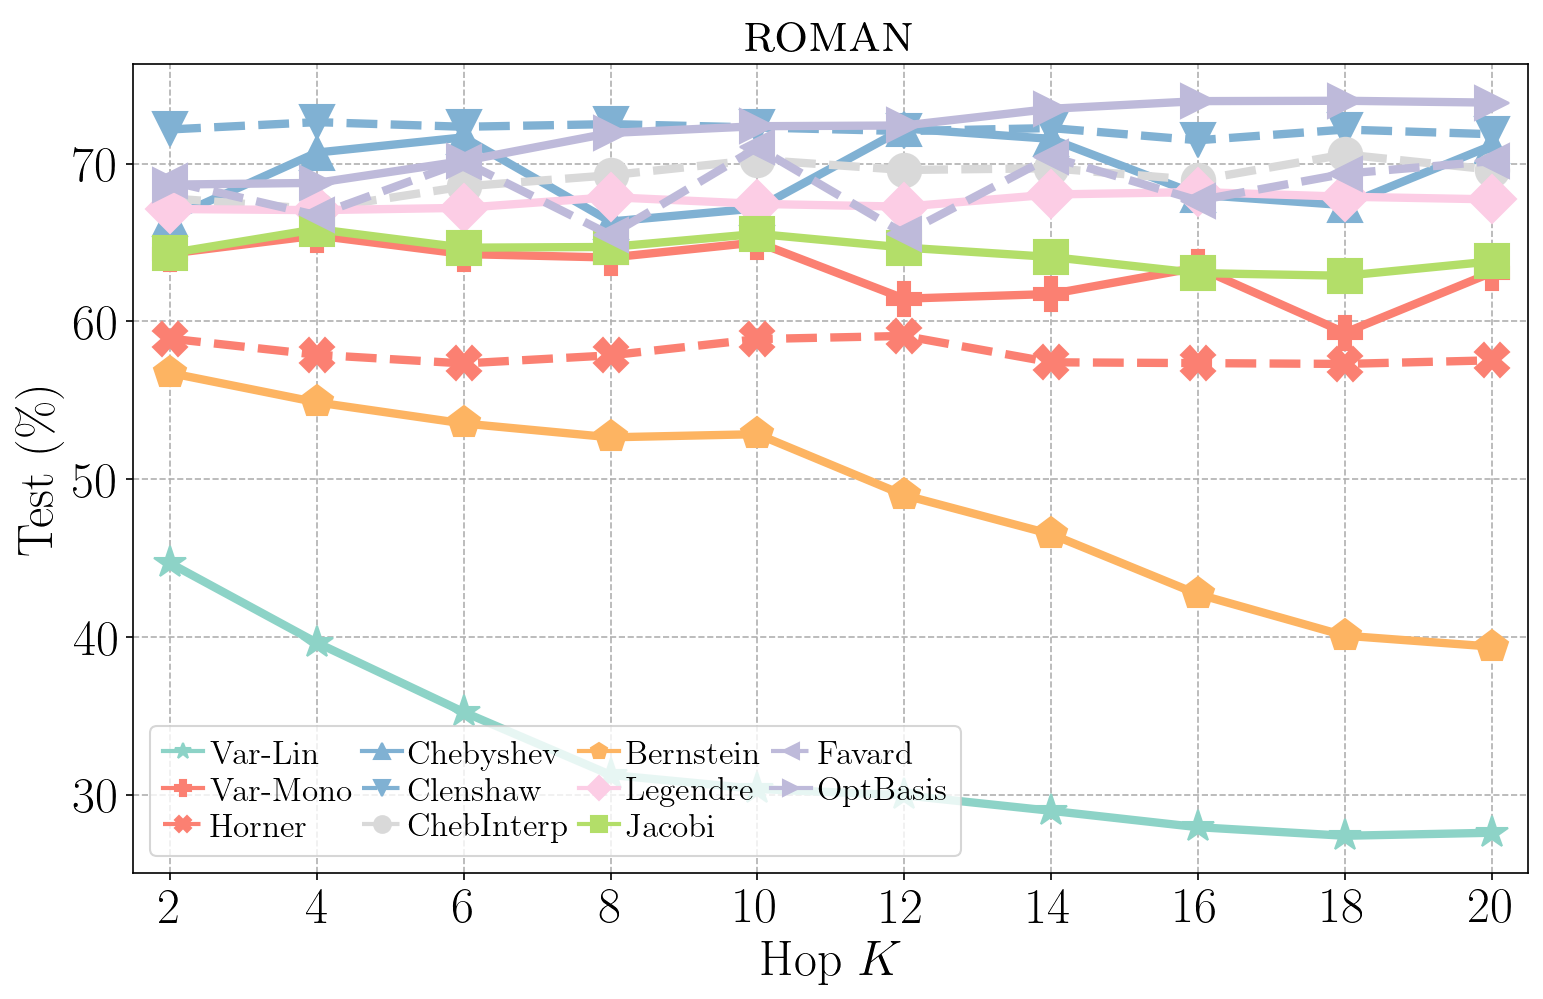

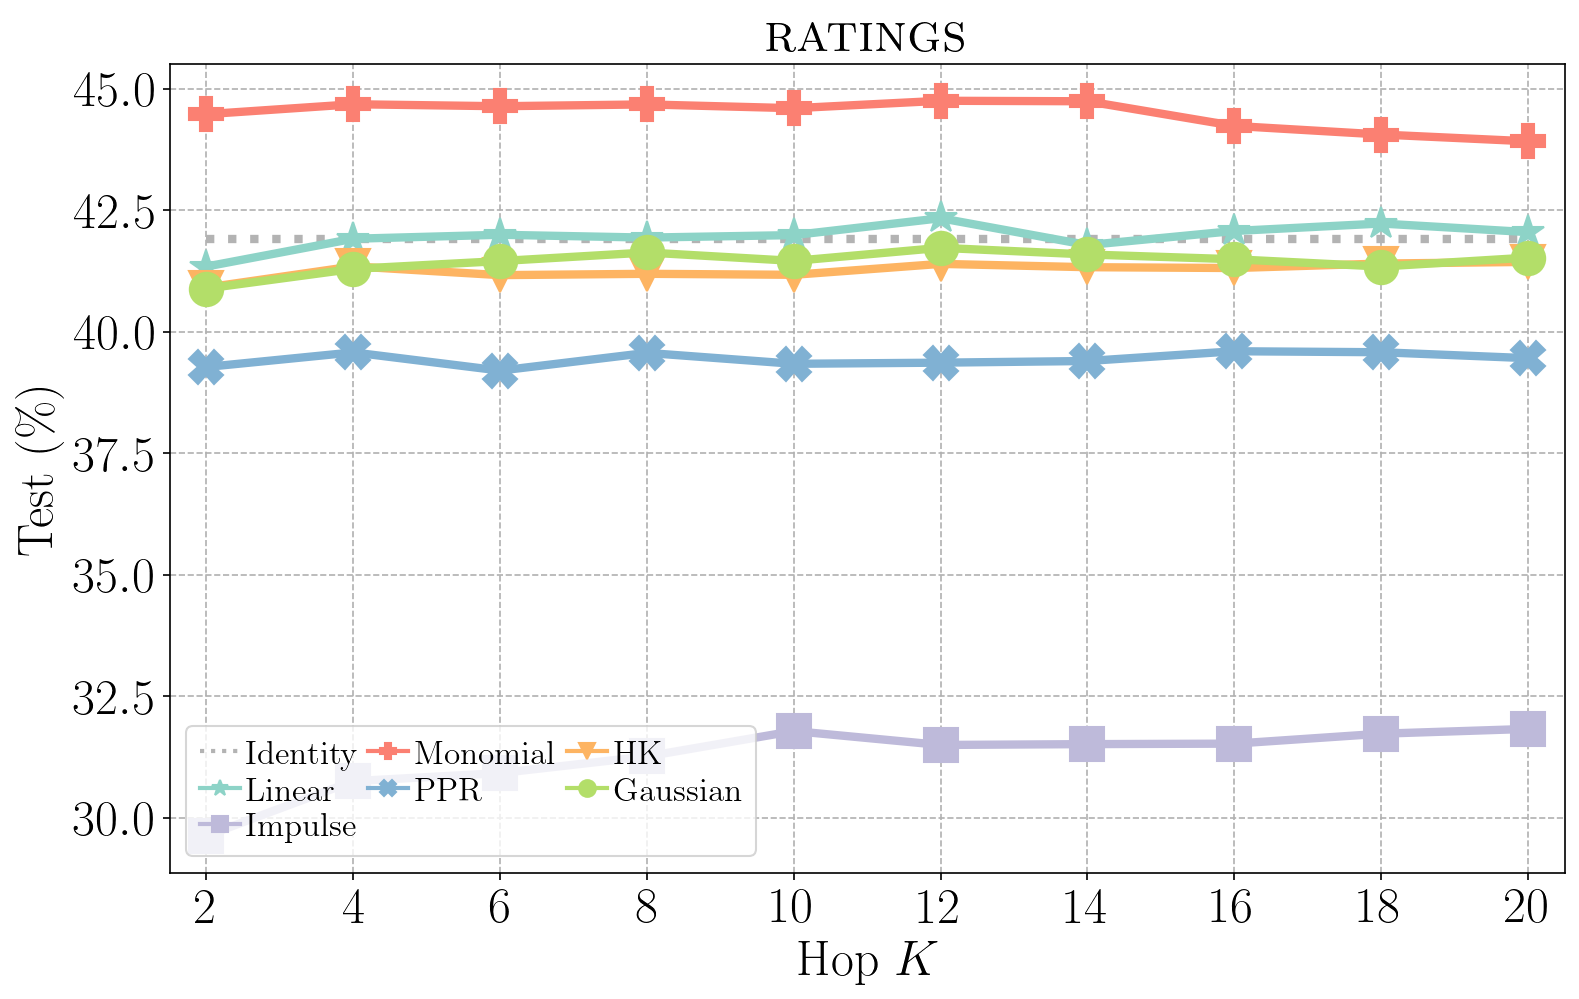

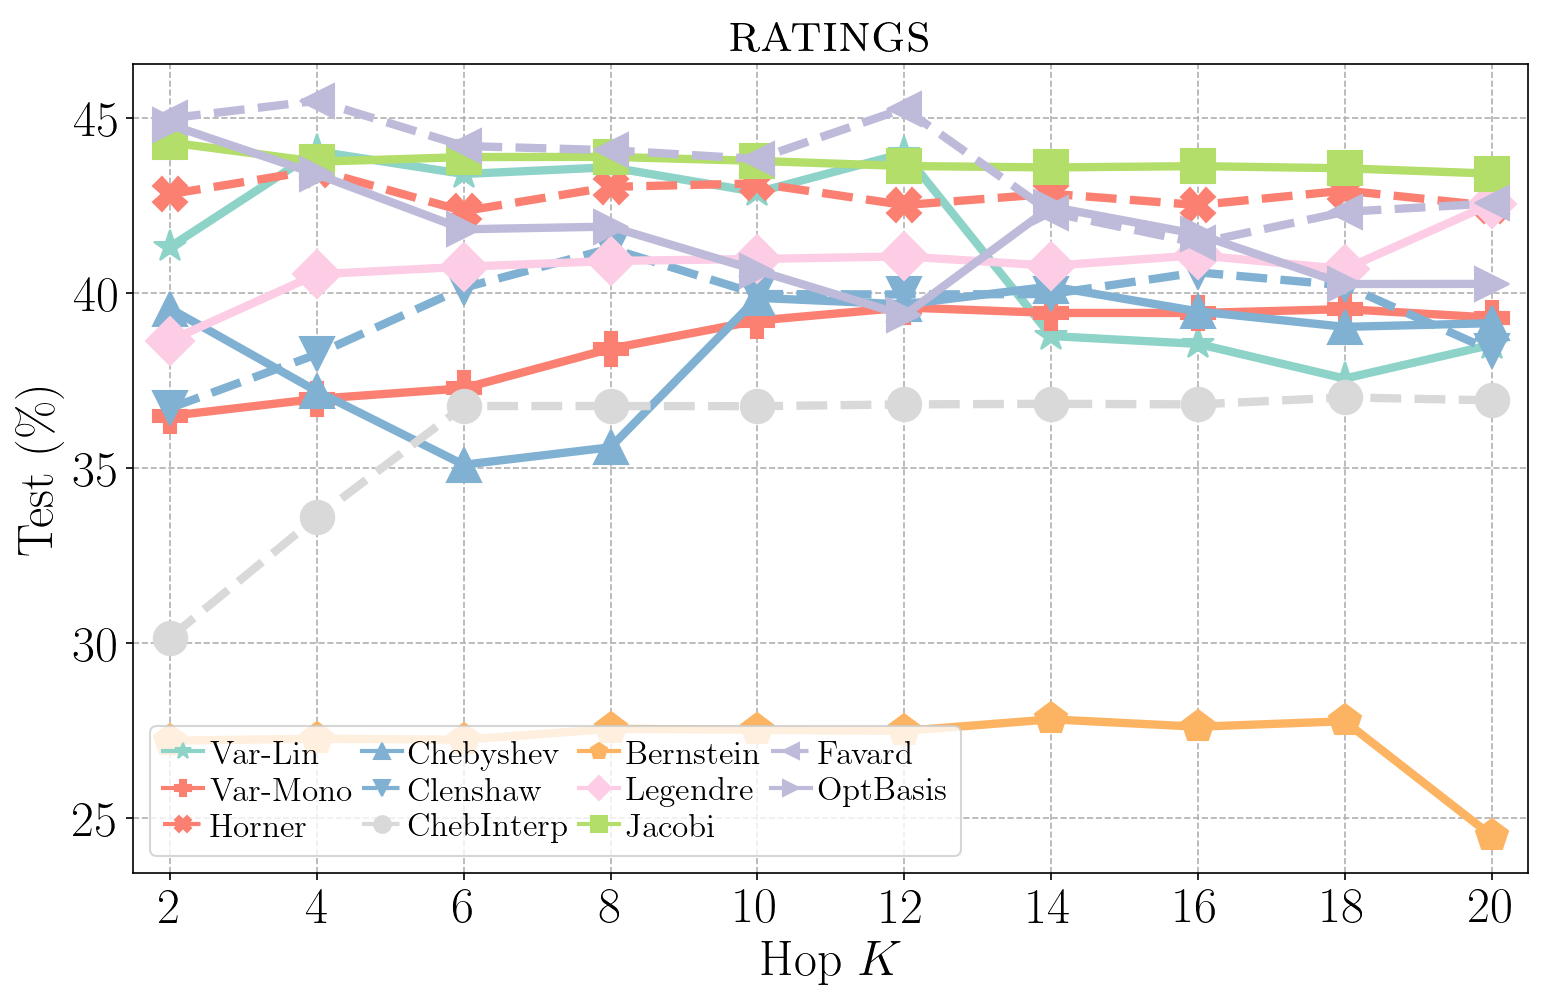

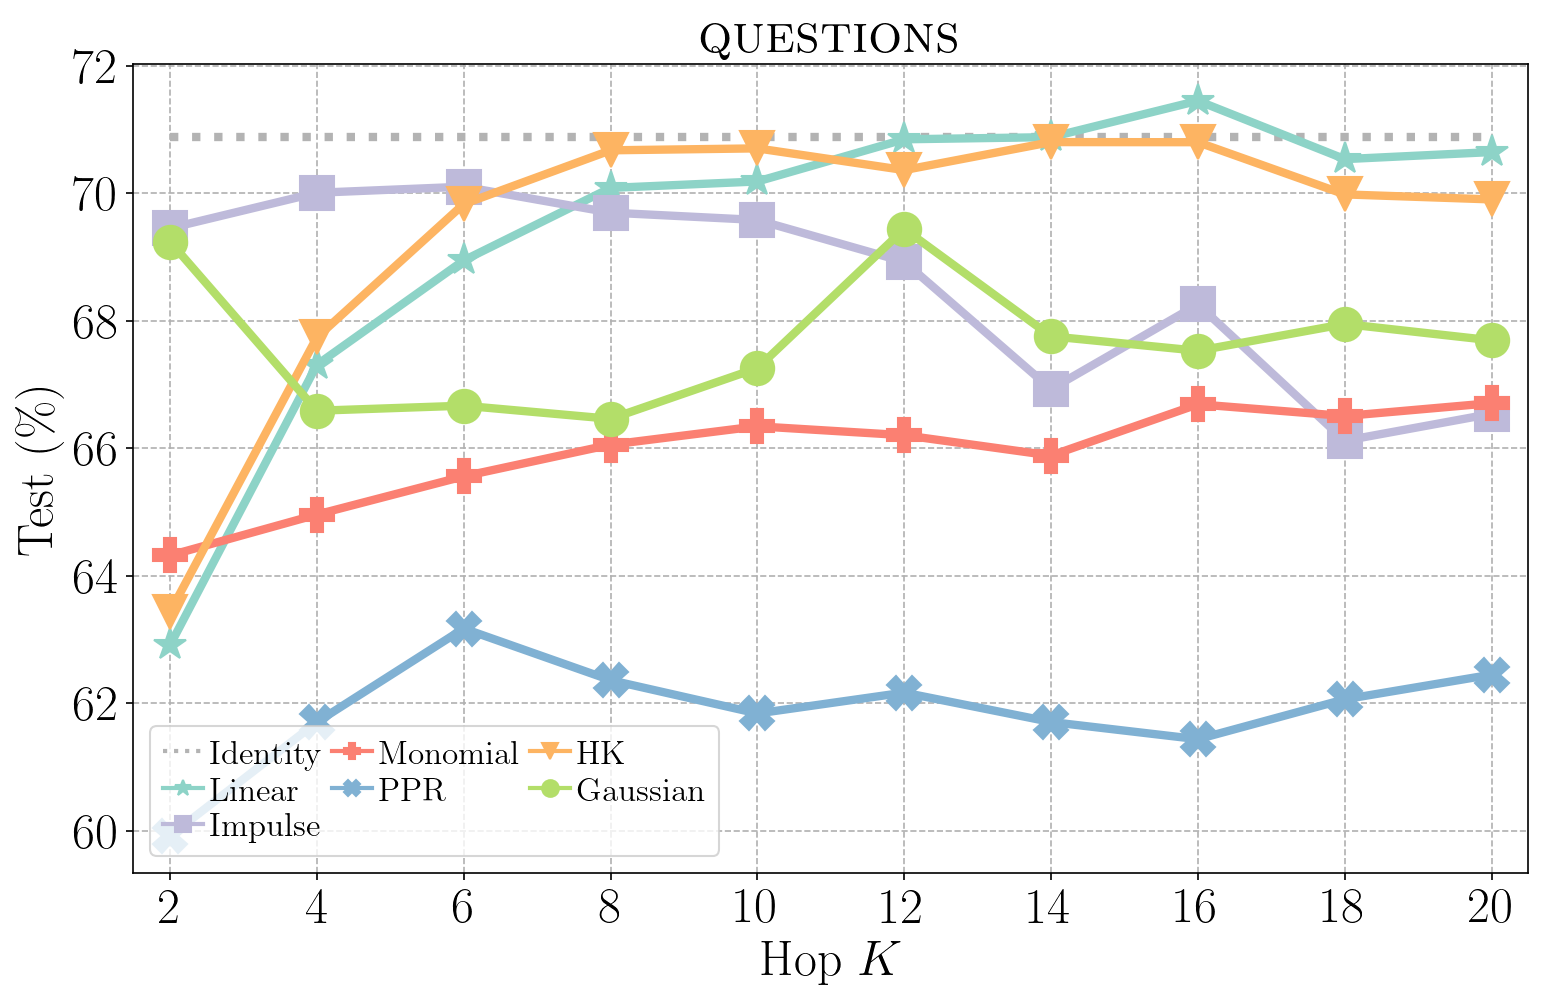

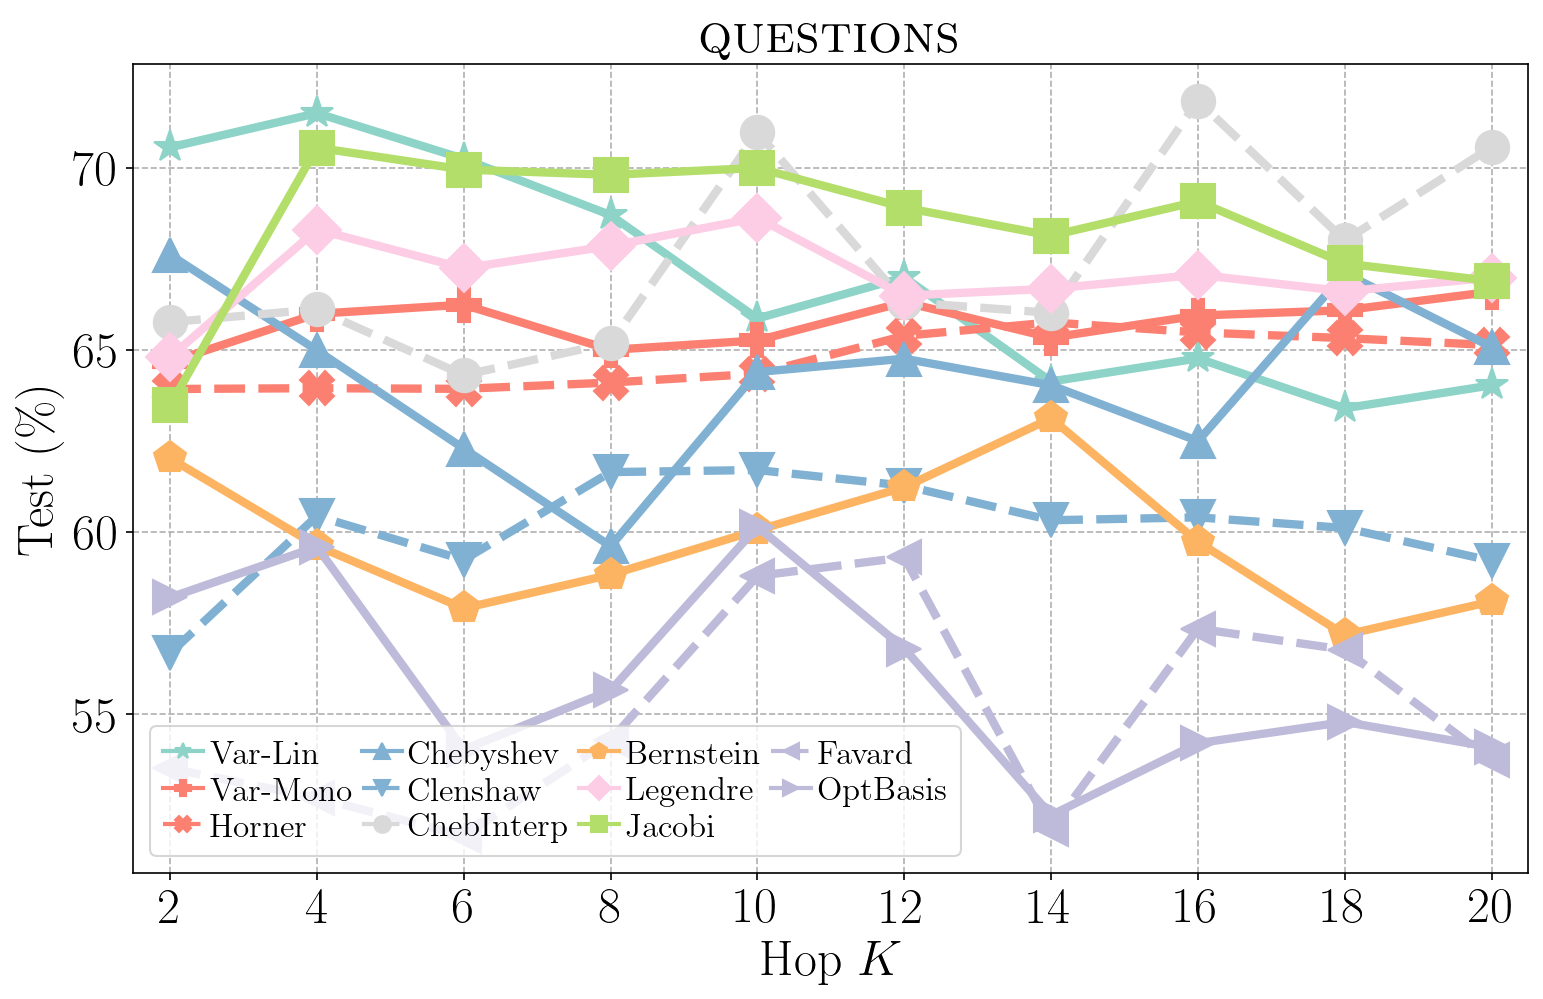

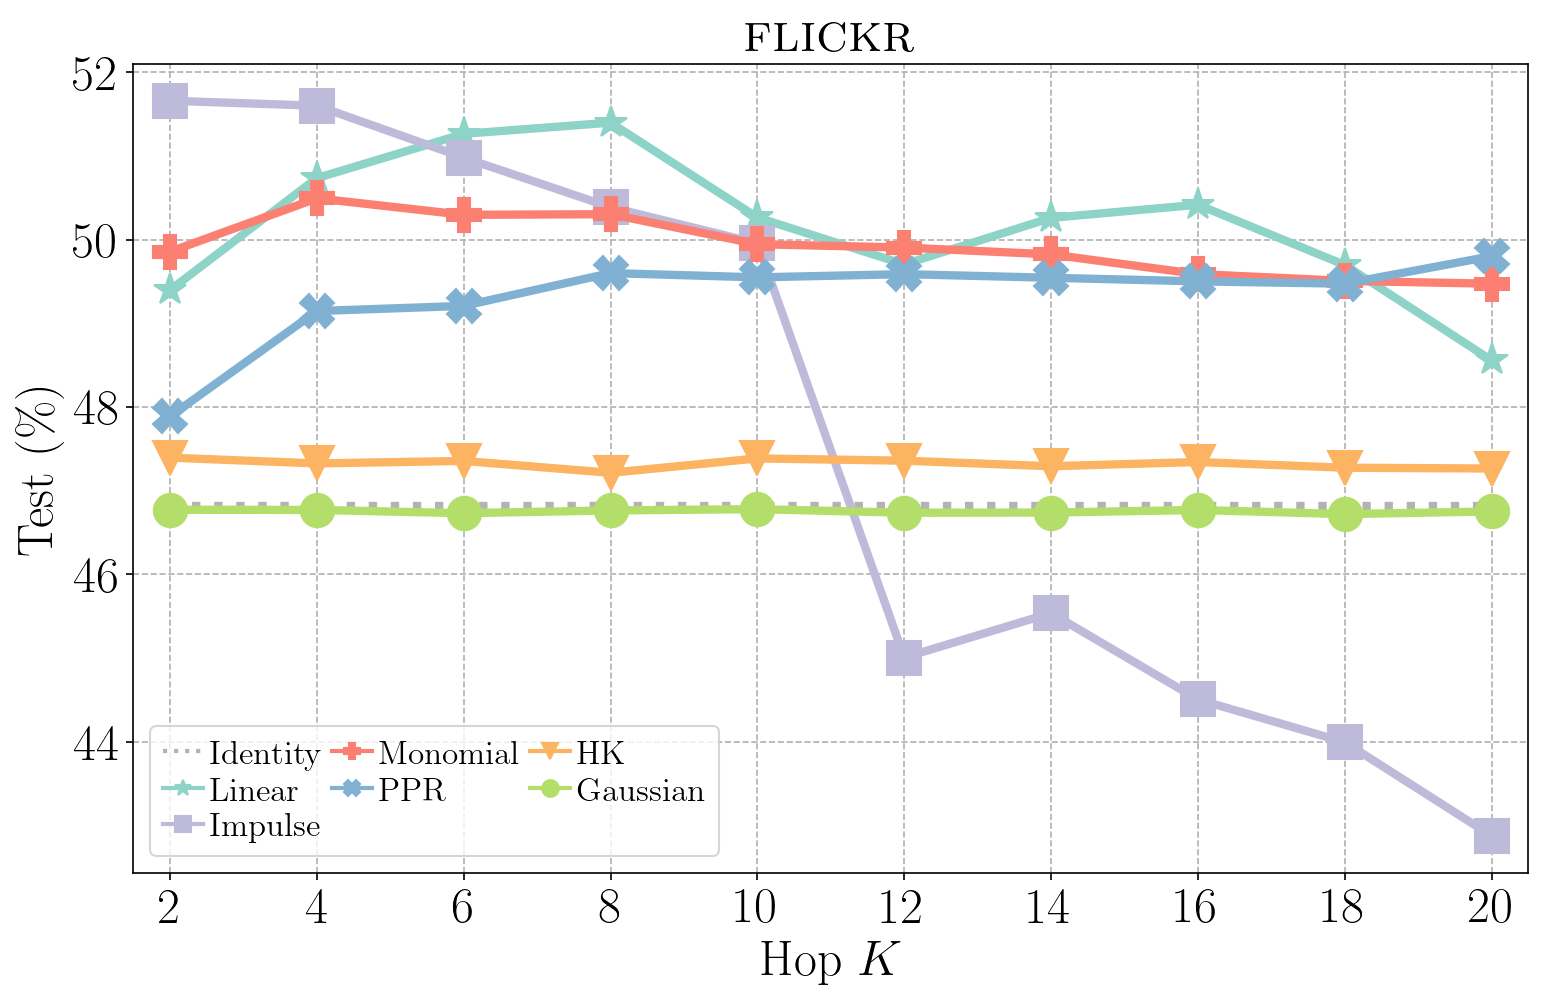

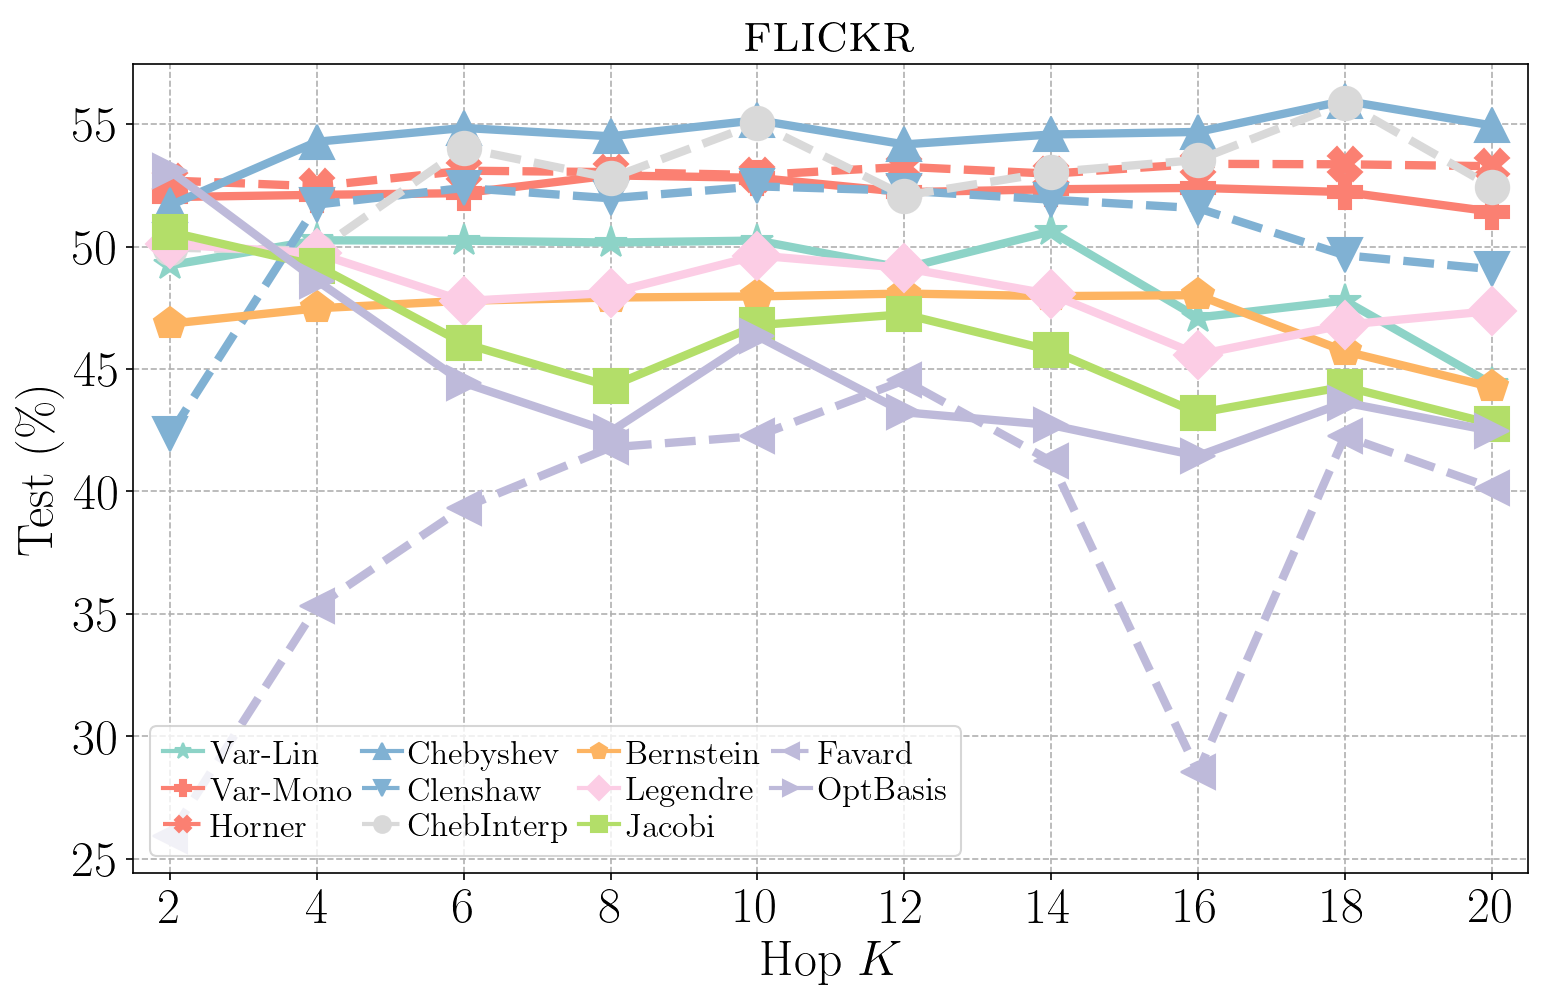

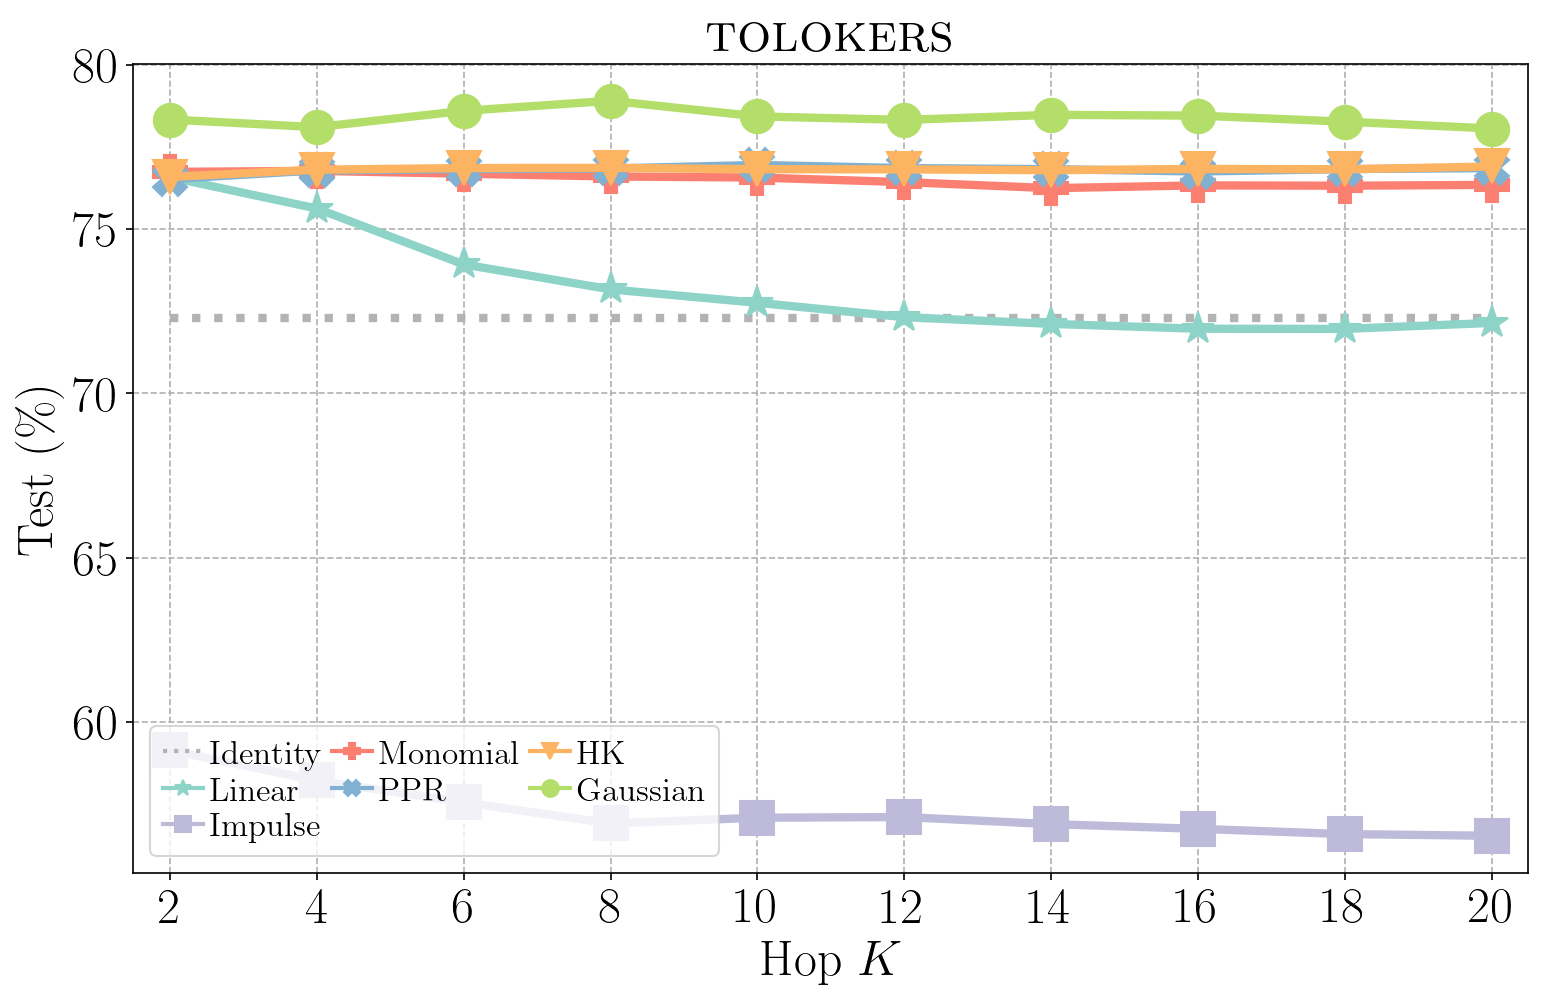

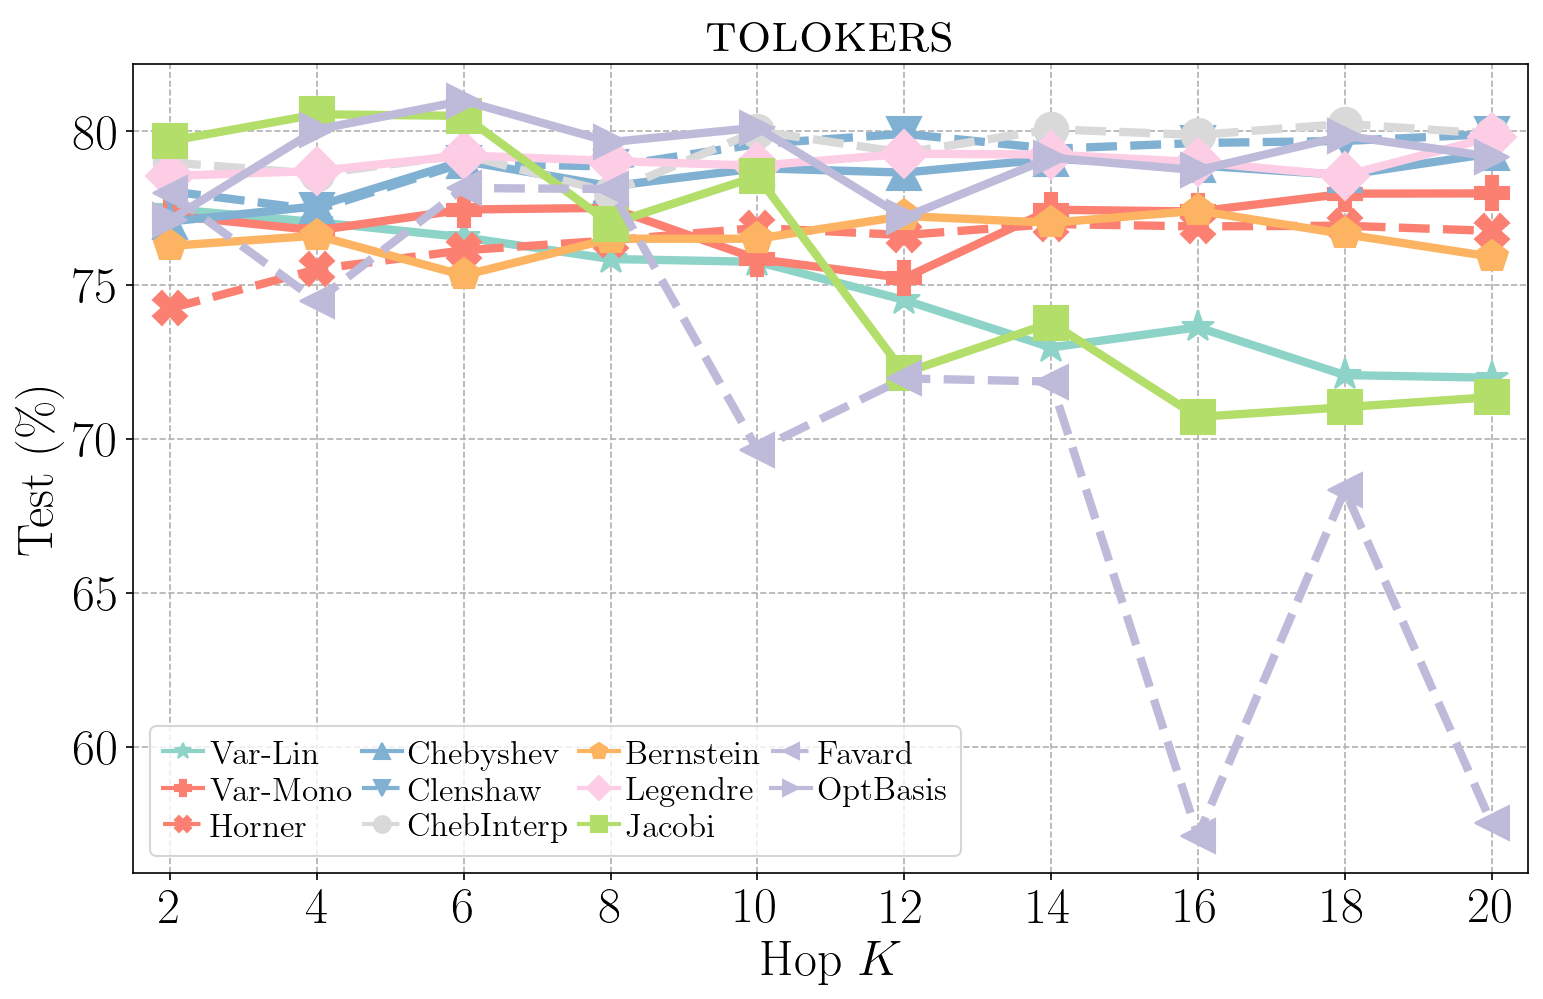

In [32]:
for d in dlst:
    fig1, ax1 = plot_acchop(d, argdct_fix)
    fig2, ax2 = plot_acchop(d, argdct_var)
    if issave:
        fig1.savefig(f'./figs/hop_fix_{d}.pdf', bbox_inches='tight')
        fig2.savefig(f'./figs/hop_var_{d}.pdf', bbox_inches='tight')